In [8]:
import random
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import os

### Data Load

In [9]:
train_idx = np.load('./train_idx.npy',allow_pickle = True)
valid_idx = np.load('./valid_idx.npy',allow_pickle = True) # 인덱스파일

In [31]:
def k_fold_split(df,fold):
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts())) # 유저 ID, 유저 수
    random.shuffle(users)

    max_train_data_len = len(df)/fold
    sum_of_train_data = 0
    val_idx =[[] for _ in range(fold)]
    val_set = []
    train_set = []

    idx = 0
    for k in range(fold-1):
        sum_of_train_data = 0
        for user_id, count in users[idx:]:
            sum_of_train_data += count
            if max_train_data_len < sum_of_train_data:
                break
            val_idx[k].append(user_id)
            idx += 1
            
    for i in range(idx,len(users)):
        val_idx[fold-1].append(users[i][0])

    for k in range(fold):
        train_set.append(df[df['userID'].isin(val_idx[k]) == False])
        val = df[df['userID'].isin(val_idx[k])]
        val_set.append(val[val['userID'] != val['userID'].shift(-1)])
    return train_set,val_set

def get_stacking_base_datasets(model,FEATS,args,X_train, X_valid, X_test, n_folds):
    
    valid_len = []
    y_valid = X_valid[0]['answerCode']
    for i,v in enumerate(X_valid):
        valid_len.append(len(v))
        if i != 0:
            y_valid = pd.concat([y_valid,v['answerCode']])
            
    train_fold_pred = np.zeros((sum(valid_len) ,1 ))
    test_pred = np.zeros((X_test.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train, valid) in enumerate(zip(X_train,X_valid)):
        
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = train[FEATS].drop(columns = 'answerCode')
        y_tr = train['answerCode']
        X_te = valid[FEATS].drop(columns = 'answerCode')
        
        
        model.fit(
            X_tr,
            y_tr,
            eval_set=(X_te,valid['answerCode']),
            **args
        )       
        
        train_fold_pred[sum(valid_len[:folder_counter]) : sum(valid_len[:folder_counter+1]), :] = model.predict_proba(X_te)[:,1].reshape(-1,1)
         
        print('\t',folder_counter,"fold auc : ",roc_auc_score(valid['answerCode'],model.predict_proba(X_te)[:,1]))

        test_pred[:, folder_counter] = model.predict_proba(X_test[FEATS].drop(columns = 'answerCode'))[:,1]

    print("\tvalid auc : ",roc_auc_score(y_valid,train_fold_pred))       
     
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    
    return train_fold_pred , test_pred_mean

def train_valid_idx(data,train_idx,valid_idx,fold):
    fold_train = []
    fold_valid = []
    for i in range(fold):
        fold_train.append(data.loc[train_idx[i],:])
        fold_valid.append(data.loc[valid_idx[i],:])
    return fold_train, fold_valid

## dataload

In [32]:
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
df = pd.read_pickle(after_fe_path)
test_set = df[df['answerCode'] == -1]
df = df[df['answerCode'] != -1]
fold_train, fold_valid = train_valid_idx(df,train_idx,valid_idx,5)

### lgbm parameter

In [68]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day',
       'hour', 'dayname', 'big_category', 'problem_num', 'mid_category',
       'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum',
       'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category',
       'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut',
       'big_category_answer', 'big_category_user_cum_acc',
       'big_category_cum_solvesec', 'big_category_mean_solvesec',
       'mid_category_cumconut', 'mid_category_answer',
       'mid_category_user_cum_acc', 'mid_category_cum_solvesec',
       'mid_category_mean_solvesec', 'problem_num_cumconut',
       'problem_num_answer', 'problem_num_user_cum_acc',
       'problem_num_cum_solvesec', 'problem_num_mean_solvesec', 'ass_acc_mean',
       'ass_acc_sum', 'ass_difficult

In [33]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx','assIdx','testIdx','KnowledgeTag',
 'user_correct_answer','user_total_answer',
 'month','day','dayname','hour',
 'test_mean','test_sum','test_std',
 'tag_mean','tag_sum','tag_std',
 'solvesec_3600', 'time_category',
 'solvesec_cumsum', 'solvecumsum_category',
 'big_category',
 'big_category_cumconut', 'big_category_user_cum_acc', 'big_category_answer',
 'big_category_cum_solvesec', 'big_category_mean_solvesec',
 'bg_category_solvesec', 'bg_category_solvesec_o', 'bg_category_solvesec_x',
 'mid_category',
 'mid_category_cumconut', 'mid_category_user_cum_acc',
 'assess_count',
 'elo_assessmentItemID','elo_problem_num',
 'ass_solvesec', 'ass_solvesec_o', 'ass_solvesec_x',
 'problem_num',
 'problem_num_solvesec','problem_num_solvesec_o','problem_num_solvesec_x']

lgbm_FEATS=FEATS+["answerCode"]

lgbm_cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
lgbm_cat_feats_idx = [i for i,e in enumerate(lgbm_FEATS) if e in lgbm_cat_feats]

lgbm_init_params = {
    "learning_rate": 0.031007037989443056,
    "n_estimators" : 4066,
    'max_depth': 4024004,
    'num_leaves': 32,
    'colsample_bytree': 0.9300204271817574
}

lgbm_fit_params = {
    "categorical_feature" : lgbm_cat_feats_idx
}

### LGBM Data Load & stacking 실행

In [34]:
# data_dir = '/opt/ml/input/data' # 경로
# after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
# df = pd.read_pickle(after_fe_path)
# test_set = df[df['answerCode'] == -1]
# df = df[df['answerCode'] != -1]
fold = 5
# fold_train,fold_valid = k_fold_split(df,fold)
lgbm = LGBMClassifier(**lgbm_init_params)
train_fold_pred , test_pred_mean = get_stacking_base_datasets(lgbm,lgbm_FEATS,lgbm_fit_params,fold_train, fold_valid, test_set, fold)

LGBMClassifier  model 시작 
	 폴드 세트:  0  시작 


/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 6, 8, 17, 19, 20, 29, 38]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's binary_logloss: 0.738222
[2]	valid_0's binary_logloss: 0.726066
[3]	valid_0's binary_logloss: 0.714776
[4]	valid_0's binary_logloss: 0.704503
[5]	valid_0's binary_logloss: 0.694744
[6]	valid_0's binary_logloss: 0.68554
[7]	valid_0's binary_logloss: 0.676976
[8]	valid_0's binary_logloss: 0.668939
[9]	valid_0's binary_logloss: 0.661345
[10]	valid_0's binary_logloss: 0.655491
[11]	valid_0's binary_logloss: 0.648704
[12]	valid_0's binary_logloss: 0.643624
[13]	valid_0's binary_logloss: 0.637798
[14]	valid_0's binary_logloss: 0.631998
[15]	valid_0's binary_logloss: 0.626521
[16]	valid_0's binary_logloss: 0.621575
[17]	valid_0's binary_logloss: 0.616661
[18]	valid_0's binary_logloss: 0.612042
[19]	valid_0's binary_logloss: 0.608432
[20]	valid_0's binary_logloss: 0.604495
[21]	valid_0's binary_logloss: 0.601416
[22]	valid_0's binary_logloss: 0.597616
[23]	valid_0's binary_logloss: 0.593891
[24]	valid_0's binary_logloss: 0.590326
[25]	valid_0's binary_logloss: 0.586982
[26]	valid

[206]	valid_0's binary_logloss: 0.508163
[207]	valid_0's binary_logloss: 0.508147
[208]	valid_0's binary_logloss: 0.508132
[209]	valid_0's binary_logloss: 0.508206
[210]	valid_0's binary_logloss: 0.508173
[211]	valid_0's binary_logloss: 0.508103
[212]	valid_0's binary_logloss: 0.508083
[213]	valid_0's binary_logloss: 0.508063
[214]	valid_0's binary_logloss: 0.507987
[215]	valid_0's binary_logloss: 0.507932
[216]	valid_0's binary_logloss: 0.507898
[217]	valid_0's binary_logloss: 0.507811
[218]	valid_0's binary_logloss: 0.507769
[219]	valid_0's binary_logloss: 0.50773
[220]	valid_0's binary_logloss: 0.507751
[221]	valid_0's binary_logloss: 0.507668
[222]	valid_0's binary_logloss: 0.507668
[223]	valid_0's binary_logloss: 0.50757
[224]	valid_0's binary_logloss: 0.507521
[225]	valid_0's binary_logloss: 0.507523
[226]	valid_0's binary_logloss: 0.507535
[227]	valid_0's binary_logloss: 0.507552
[228]	valid_0's binary_logloss: 0.507443
[229]	valid_0's binary_logloss: 0.507412
[230]	valid_0's bi

[407]	valid_0's binary_logloss: 0.50376
[408]	valid_0's binary_logloss: 0.50376
[409]	valid_0's binary_logloss: 0.503723
[410]	valid_0's binary_logloss: 0.503742
[411]	valid_0's binary_logloss: 0.503756
[412]	valid_0's binary_logloss: 0.503743
[413]	valid_0's binary_logloss: 0.50375
[414]	valid_0's binary_logloss: 0.50374
[415]	valid_0's binary_logloss: 0.50374
[416]	valid_0's binary_logloss: 0.503688
[417]	valid_0's binary_logloss: 0.503723
[418]	valid_0's binary_logloss: 0.503722
[419]	valid_0's binary_logloss: 0.503723
[420]	valid_0's binary_logloss: 0.503668
[421]	valid_0's binary_logloss: 0.503646
[422]	valid_0's binary_logloss: 0.503647
[423]	valid_0's binary_logloss: 0.503609
[424]	valid_0's binary_logloss: 0.503602
[425]	valid_0's binary_logloss: 0.503563
[426]	valid_0's binary_logloss: 0.503567
[427]	valid_0's binary_logloss: 0.503607
[428]	valid_0's binary_logloss: 0.503593
[429]	valid_0's binary_logloss: 0.503588
[430]	valid_0's binary_logloss: 0.503583
[431]	valid_0's binar

[608]	valid_0's binary_logloss: 0.502651
[609]	valid_0's binary_logloss: 0.502628
[610]	valid_0's binary_logloss: 0.502626
[611]	valid_0's binary_logloss: 0.502628
[612]	valid_0's binary_logloss: 0.502636
[613]	valid_0's binary_logloss: 0.502665
[614]	valid_0's binary_logloss: 0.502671
[615]	valid_0's binary_logloss: 0.502672
[616]	valid_0's binary_logloss: 0.502663
[617]	valid_0's binary_logloss: 0.502639
[618]	valid_0's binary_logloss: 0.502634
[619]	valid_0's binary_logloss: 0.502635
[620]	valid_0's binary_logloss: 0.502614
[621]	valid_0's binary_logloss: 0.502617
[622]	valid_0's binary_logloss: 0.502596
[623]	valid_0's binary_logloss: 0.502594
[624]	valid_0's binary_logloss: 0.502609
[625]	valid_0's binary_logloss: 0.50261
[626]	valid_0's binary_logloss: 0.502547
[627]	valid_0's binary_logloss: 0.502557
[628]	valid_0's binary_logloss: 0.50251
[629]	valid_0's binary_logloss: 0.50252
[630]	valid_0's binary_logloss: 0.502543
[631]	valid_0's binary_logloss: 0.502543
[632]	valid_0's bin

[809]	valid_0's binary_logloss: 0.502155
[810]	valid_0's binary_logloss: 0.502163
[811]	valid_0's binary_logloss: 0.502146
[812]	valid_0's binary_logloss: 0.502148
[813]	valid_0's binary_logloss: 0.502149
[814]	valid_0's binary_logloss: 0.502142
[815]	valid_0's binary_logloss: 0.502132
[816]	valid_0's binary_logloss: 0.502186
[817]	valid_0's binary_logloss: 0.502197
[818]	valid_0's binary_logloss: 0.502192
[819]	valid_0's binary_logloss: 0.502195
[820]	valid_0's binary_logloss: 0.502181
[821]	valid_0's binary_logloss: 0.502251
[822]	valid_0's binary_logloss: 0.502258
[823]	valid_0's binary_logloss: 0.502258
[824]	valid_0's binary_logloss: 0.50225
[825]	valid_0's binary_logloss: 0.502245
[826]	valid_0's binary_logloss: 0.502249
[827]	valid_0's binary_logloss: 0.502275
[828]	valid_0's binary_logloss: 0.50226
[829]	valid_0's binary_logloss: 0.50226
[830]	valid_0's binary_logloss: 0.502229
[831]	valid_0's binary_logloss: 0.502234
[832]	valid_0's binary_logloss: 0.502235
[833]	valid_0's bin

[1011]	valid_0's binary_logloss: 0.502236
[1012]	valid_0's binary_logloss: 0.502244
[1013]	valid_0's binary_logloss: 0.502239
[1014]	valid_0's binary_logloss: 0.502223
[1015]	valid_0's binary_logloss: 0.502215
[1016]	valid_0's binary_logloss: 0.502214
[1017]	valid_0's binary_logloss: 0.502206
[1018]	valid_0's binary_logloss: 0.502198
[1019]	valid_0's binary_logloss: 0.502196
[1020]	valid_0's binary_logloss: 0.502202
[1021]	valid_0's binary_logloss: 0.502193
[1022]	valid_0's binary_logloss: 0.502199
[1023]	valid_0's binary_logloss: 0.502201
[1024]	valid_0's binary_logloss: 0.502237
[1025]	valid_0's binary_logloss: 0.502237
[1026]	valid_0's binary_logloss: 0.502239
[1027]	valid_0's binary_logloss: 0.502261
[1028]	valid_0's binary_logloss: 0.502267
[1029]	valid_0's binary_logloss: 0.502269
[1030]	valid_0's binary_logloss: 0.502276
[1031]	valid_0's binary_logloss: 0.502267
[1032]	valid_0's binary_logloss: 0.502249
[1033]	valid_0's binary_logloss: 0.502242
[1034]	valid_0's binary_logloss: 0

[1207]	valid_0's binary_logloss: 0.502306
[1208]	valid_0's binary_logloss: 0.502314
[1209]	valid_0's binary_logloss: 0.50234
[1210]	valid_0's binary_logloss: 0.502329
[1211]	valid_0's binary_logloss: 0.502323
[1212]	valid_0's binary_logloss: 0.502326
[1213]	valid_0's binary_logloss: 0.502331
[1214]	valid_0's binary_logloss: 0.50232
[1215]	valid_0's binary_logloss: 0.502317
[1216]	valid_0's binary_logloss: 0.502298
[1217]	valid_0's binary_logloss: 0.502306
[1218]	valid_0's binary_logloss: 0.50231
[1219]	valid_0's binary_logloss: 0.502306
[1220]	valid_0's binary_logloss: 0.502324
[1221]	valid_0's binary_logloss: 0.50229
[1222]	valid_0's binary_logloss: 0.502292
[1223]	valid_0's binary_logloss: 0.502327
[1224]	valid_0's binary_logloss: 0.502357
[1225]	valid_0's binary_logloss: 0.502351
[1226]	valid_0's binary_logloss: 0.502344
[1227]	valid_0's binary_logloss: 0.502309
[1228]	valid_0's binary_logloss: 0.50231
[1229]	valid_0's binary_logloss: 0.502307
[1230]	valid_0's binary_logloss: 0.5022

[1403]	valid_0's binary_logloss: 0.502453
[1404]	valid_0's binary_logloss: 0.502441
[1405]	valid_0's binary_logloss: 0.502437
[1406]	valid_0's binary_logloss: 0.502422
[1407]	valid_0's binary_logloss: 0.502411
[1408]	valid_0's binary_logloss: 0.502411
[1409]	valid_0's binary_logloss: 0.502398
[1410]	valid_0's binary_logloss: 0.502403
[1411]	valid_0's binary_logloss: 0.502393
[1412]	valid_0's binary_logloss: 0.502393
[1413]	valid_0's binary_logloss: 0.502381
[1414]	valid_0's binary_logloss: 0.502395
[1415]	valid_0's binary_logloss: 0.502396
[1416]	valid_0's binary_logloss: 0.502387
[1417]	valid_0's binary_logloss: 0.502382
[1418]	valid_0's binary_logloss: 0.502434
[1419]	valid_0's binary_logloss: 0.502447
[1420]	valid_0's binary_logloss: 0.5025
[1421]	valid_0's binary_logloss: 0.502506
[1422]	valid_0's binary_logloss: 0.502526
[1423]	valid_0's binary_logloss: 0.50256
[1424]	valid_0's binary_logloss: 0.502565
[1425]	valid_0's binary_logloss: 0.502565
[1426]	valid_0's binary_logloss: 0.50

[1600]	valid_0's binary_logloss: 0.502723
[1601]	valid_0's binary_logloss: 0.502727
[1602]	valid_0's binary_logloss: 0.502723
[1603]	valid_0's binary_logloss: 0.502722
[1604]	valid_0's binary_logloss: 0.502717
[1605]	valid_0's binary_logloss: 0.502698
[1606]	valid_0's binary_logloss: 0.502716
[1607]	valid_0's binary_logloss: 0.502719
[1608]	valid_0's binary_logloss: 0.5027
[1609]	valid_0's binary_logloss: 0.502721
[1610]	valid_0's binary_logloss: 0.502743
[1611]	valid_0's binary_logloss: 0.502754
[1612]	valid_0's binary_logloss: 0.502747
[1613]	valid_0's binary_logloss: 0.502744
[1614]	valid_0's binary_logloss: 0.502751
[1615]	valid_0's binary_logloss: 0.502745
[1616]	valid_0's binary_logloss: 0.502729
[1617]	valid_0's binary_logloss: 0.502711
[1618]	valid_0's binary_logloss: 0.502711
[1619]	valid_0's binary_logloss: 0.502697
[1620]	valid_0's binary_logloss: 0.502691
[1621]	valid_0's binary_logloss: 0.502693
[1622]	valid_0's binary_logloss: 0.502645
[1623]	valid_0's binary_logloss: 0.5

[1797]	valid_0's binary_logloss: 0.502954
[1798]	valid_0's binary_logloss: 0.502961
[1799]	valid_0's binary_logloss: 0.50296
[1800]	valid_0's binary_logloss: 0.502967
[1801]	valid_0's binary_logloss: 0.502973
[1802]	valid_0's binary_logloss: 0.503005
[1803]	valid_0's binary_logloss: 0.50299
[1804]	valid_0's binary_logloss: 0.502988
[1805]	valid_0's binary_logloss: 0.502961
[1806]	valid_0's binary_logloss: 0.502971
[1807]	valid_0's binary_logloss: 0.502972
[1808]	valid_0's binary_logloss: 0.502973
[1809]	valid_0's binary_logloss: 0.502976
[1810]	valid_0's binary_logloss: 0.502974
[1811]	valid_0's binary_logloss: 0.502972
[1812]	valid_0's binary_logloss: 0.502976
[1813]	valid_0's binary_logloss: 0.502981
[1814]	valid_0's binary_logloss: 0.50299
[1815]	valid_0's binary_logloss: 0.50299
[1816]	valid_0's binary_logloss: 0.502987
[1817]	valid_0's binary_logloss: 0.502988
[1818]	valid_0's binary_logloss: 0.502984
[1819]	valid_0's binary_logloss: 0.502986
[1820]	valid_0's binary_logloss: 0.502

[1993]	valid_0's binary_logloss: 0.502827
[1994]	valid_0's binary_logloss: 0.502824
[1995]	valid_0's binary_logloss: 0.502821
[1996]	valid_0's binary_logloss: 0.502827
[1997]	valid_0's binary_logloss: 0.50283
[1998]	valid_0's binary_logloss: 0.502834
[1999]	valid_0's binary_logloss: 0.502833
[2000]	valid_0's binary_logloss: 0.502826
[2001]	valid_0's binary_logloss: 0.502826
[2002]	valid_0's binary_logloss: 0.502824
[2003]	valid_0's binary_logloss: 0.502834
[2004]	valid_0's binary_logloss: 0.502818
[2005]	valid_0's binary_logloss: 0.502815
[2006]	valid_0's binary_logloss: 0.502812
[2007]	valid_0's binary_logloss: 0.502829
[2008]	valid_0's binary_logloss: 0.50283
[2009]	valid_0's binary_logloss: 0.502848
[2010]	valid_0's binary_logloss: 0.502849
[2011]	valid_0's binary_logloss: 0.502849
[2012]	valid_0's binary_logloss: 0.50285
[2013]	valid_0's binary_logloss: 0.502838
[2014]	valid_0's binary_logloss: 0.502852
[2015]	valid_0's binary_logloss: 0.502846
[2016]	valid_0's binary_logloss: 0.50

[2190]	valid_0's binary_logloss: 0.50339
[2191]	valid_0's binary_logloss: 0.503389
[2192]	valid_0's binary_logloss: 0.503379
[2193]	valid_0's binary_logloss: 0.503379
[2194]	valid_0's binary_logloss: 0.503378
[2195]	valid_0's binary_logloss: 0.503366
[2196]	valid_0's binary_logloss: 0.503372
[2197]	valid_0's binary_logloss: 0.503369
[2198]	valid_0's binary_logloss: 0.503371
[2199]	valid_0's binary_logloss: 0.503364
[2200]	valid_0's binary_logloss: 0.503366
[2201]	valid_0's binary_logloss: 0.503367
[2202]	valid_0's binary_logloss: 0.503368
[2203]	valid_0's binary_logloss: 0.503353
[2204]	valid_0's binary_logloss: 0.503348
[2205]	valid_0's binary_logloss: 0.503322
[2206]	valid_0's binary_logloss: 0.503291
[2207]	valid_0's binary_logloss: 0.503275
[2208]	valid_0's binary_logloss: 0.503275
[2209]	valid_0's binary_logloss: 0.503287
[2210]	valid_0's binary_logloss: 0.503286
[2211]	valid_0's binary_logloss: 0.503291
[2212]	valid_0's binary_logloss: 0.503293
[2213]	valid_0's binary_logloss: 0.

[2389]	valid_0's binary_logloss: 0.503296
[2390]	valid_0's binary_logloss: 0.503296
[2391]	valid_0's binary_logloss: 0.503293
[2392]	valid_0's binary_logloss: 0.503293
[2393]	valid_0's binary_logloss: 0.503276
[2394]	valid_0's binary_logloss: 0.503275
[2395]	valid_0's binary_logloss: 0.503271
[2396]	valid_0's binary_logloss: 0.503315
[2397]	valid_0's binary_logloss: 0.503313
[2398]	valid_0's binary_logloss: 0.503317
[2399]	valid_0's binary_logloss: 0.503318
[2400]	valid_0's binary_logloss: 0.503318
[2401]	valid_0's binary_logloss: 0.503316
[2402]	valid_0's binary_logloss: 0.503325
[2403]	valid_0's binary_logloss: 0.503332
[2404]	valid_0's binary_logloss: 0.503344
[2405]	valid_0's binary_logloss: 0.503342
[2406]	valid_0's binary_logloss: 0.503314
[2407]	valid_0's binary_logloss: 0.503314
[2408]	valid_0's binary_logloss: 0.50332
[2409]	valid_0's binary_logloss: 0.503343
[2410]	valid_0's binary_logloss: 0.503344
[2411]	valid_0's binary_logloss: 0.503344
[2412]	valid_0's binary_logloss: 0.

[2588]	valid_0's binary_logloss: 0.50369
[2589]	valid_0's binary_logloss: 0.503677
[2590]	valid_0's binary_logloss: 0.503675
[2591]	valid_0's binary_logloss: 0.503661
[2592]	valid_0's binary_logloss: 0.503652
[2593]	valid_0's binary_logloss: 0.503664
[2594]	valid_0's binary_logloss: 0.503667
[2595]	valid_0's binary_logloss: 0.503667
[2596]	valid_0's binary_logloss: 0.503639
[2597]	valid_0's binary_logloss: 0.503636
[2598]	valid_0's binary_logloss: 0.503626
[2599]	valid_0's binary_logloss: 0.503632
[2600]	valid_0's binary_logloss: 0.503628
[2601]	valid_0's binary_logloss: 0.503629
[2602]	valid_0's binary_logloss: 0.503629
[2603]	valid_0's binary_logloss: 0.503637
[2604]	valid_0's binary_logloss: 0.503621
[2605]	valid_0's binary_logloss: 0.503629
[2606]	valid_0's binary_logloss: 0.50363
[2607]	valid_0's binary_logloss: 0.503624
[2608]	valid_0's binary_logloss: 0.503607
[2609]	valid_0's binary_logloss: 0.503619
[2610]	valid_0's binary_logloss: 0.503631
[2611]	valid_0's binary_logloss: 0.5

[2784]	valid_0's binary_logloss: 0.504077
[2785]	valid_0's binary_logloss: 0.504072
[2786]	valid_0's binary_logloss: 0.504074
[2787]	valid_0's binary_logloss: 0.504095
[2788]	valid_0's binary_logloss: 0.504095
[2789]	valid_0's binary_logloss: 0.504093
[2790]	valid_0's binary_logloss: 0.504095
[2791]	valid_0's binary_logloss: 0.504099
[2792]	valid_0's binary_logloss: 0.504111
[2793]	valid_0's binary_logloss: 0.504102
[2794]	valid_0's binary_logloss: 0.504119
[2795]	valid_0's binary_logloss: 0.504122
[2796]	valid_0's binary_logloss: 0.504106
[2797]	valid_0's binary_logloss: 0.504107
[2798]	valid_0's binary_logloss: 0.504102
[2799]	valid_0's binary_logloss: 0.504102
[2800]	valid_0's binary_logloss: 0.504101
[2801]	valid_0's binary_logloss: 0.504105
[2802]	valid_0's binary_logloss: 0.504113
[2803]	valid_0's binary_logloss: 0.504125
[2804]	valid_0's binary_logloss: 0.504136
[2805]	valid_0's binary_logloss: 0.504147
[2806]	valid_0's binary_logloss: 0.504146
[2807]	valid_0's binary_logloss: 0

[2982]	valid_0's binary_logloss: 0.504519
[2983]	valid_0's binary_logloss: 0.504519
[2984]	valid_0's binary_logloss: 0.504519
[2985]	valid_0's binary_logloss: 0.504518
[2986]	valid_0's binary_logloss: 0.504521
[2987]	valid_0's binary_logloss: 0.504529
[2988]	valid_0's binary_logloss: 0.504516
[2989]	valid_0's binary_logloss: 0.504516
[2990]	valid_0's binary_logloss: 0.504511
[2991]	valid_0's binary_logloss: 0.504519
[2992]	valid_0's binary_logloss: 0.504518
[2993]	valid_0's binary_logloss: 0.504511
[2994]	valid_0's binary_logloss: 0.504511
[2995]	valid_0's binary_logloss: 0.504511
[2996]	valid_0's binary_logloss: 0.504506
[2997]	valid_0's binary_logloss: 0.504507
[2998]	valid_0's binary_logloss: 0.504506
[2999]	valid_0's binary_logloss: 0.504506
[3000]	valid_0's binary_logloss: 0.50451
[3001]	valid_0's binary_logloss: 0.504503
[3002]	valid_0's binary_logloss: 0.504512
[3003]	valid_0's binary_logloss: 0.504518
[3004]	valid_0's binary_logloss: 0.504483
[3005]	valid_0's binary_logloss: 0.

[3180]	valid_0's binary_logloss: 0.505018
[3181]	valid_0's binary_logloss: 0.505013
[3182]	valid_0's binary_logloss: 0.50504
[3183]	valid_0's binary_logloss: 0.505039
[3184]	valid_0's binary_logloss: 0.505051
[3185]	valid_0's binary_logloss: 0.505057
[3186]	valid_0's binary_logloss: 0.505061
[3187]	valid_0's binary_logloss: 0.505061
[3188]	valid_0's binary_logloss: 0.505057
[3189]	valid_0's binary_logloss: 0.505058
[3190]	valid_0's binary_logloss: 0.505071
[3191]	valid_0's binary_logloss: 0.505075
[3192]	valid_0's binary_logloss: 0.505109
[3193]	valid_0's binary_logloss: 0.505109
[3194]	valid_0's binary_logloss: 0.505105
[3195]	valid_0's binary_logloss: 0.505104
[3196]	valid_0's binary_logloss: 0.505102
[3197]	valid_0's binary_logloss: 0.505146
[3198]	valid_0's binary_logloss: 0.505122
[3199]	valid_0's binary_logloss: 0.505114
[3200]	valid_0's binary_logloss: 0.505125
[3201]	valid_0's binary_logloss: 0.505118
[3202]	valid_0's binary_logloss: 0.505122
[3203]	valid_0's binary_logloss: 0.

[3379]	valid_0's binary_logloss: 0.505636
[3380]	valid_0's binary_logloss: 0.505636
[3381]	valid_0's binary_logloss: 0.505659
[3382]	valid_0's binary_logloss: 0.505697
[3383]	valid_0's binary_logloss: 0.505723
[3384]	valid_0's binary_logloss: 0.505727
[3385]	valid_0's binary_logloss: 0.505722
[3386]	valid_0's binary_logloss: 0.505723
[3387]	valid_0's binary_logloss: 0.505727
[3388]	valid_0's binary_logloss: 0.505748
[3389]	valid_0's binary_logloss: 0.505743
[3390]	valid_0's binary_logloss: 0.505751
[3391]	valid_0's binary_logloss: 0.505765
[3392]	valid_0's binary_logloss: 0.505785
[3393]	valid_0's binary_logloss: 0.505777
[3394]	valid_0's binary_logloss: 0.505777
[3395]	valid_0's binary_logloss: 0.505774
[3396]	valid_0's binary_logloss: 0.505779
[3397]	valid_0's binary_logloss: 0.505782
[3398]	valid_0's binary_logloss: 0.505777
[3399]	valid_0's binary_logloss: 0.505777
[3400]	valid_0's binary_logloss: 0.505775
[3401]	valid_0's binary_logloss: 0.505774
[3402]	valid_0's binary_logloss: 0

[3576]	valid_0's binary_logloss: 0.50604
[3577]	valid_0's binary_logloss: 0.506039
[3578]	valid_0's binary_logloss: 0.506057
[3579]	valid_0's binary_logloss: 0.506078
[3580]	valid_0's binary_logloss: 0.506085
[3581]	valid_0's binary_logloss: 0.506094
[3582]	valid_0's binary_logloss: 0.506094
[3583]	valid_0's binary_logloss: 0.506086
[3584]	valid_0's binary_logloss: 0.506082
[3585]	valid_0's binary_logloss: 0.506101
[3586]	valid_0's binary_logloss: 0.506097
[3587]	valid_0's binary_logloss: 0.506108
[3588]	valid_0's binary_logloss: 0.506108
[3589]	valid_0's binary_logloss: 0.506105
[3590]	valid_0's binary_logloss: 0.506111
[3591]	valid_0's binary_logloss: 0.506111
[3592]	valid_0's binary_logloss: 0.506127
[3593]	valid_0's binary_logloss: 0.506131
[3594]	valid_0's binary_logloss: 0.506136
[3595]	valid_0's binary_logloss: 0.506143
[3596]	valid_0's binary_logloss: 0.506151
[3597]	valid_0's binary_logloss: 0.506155
[3598]	valid_0's binary_logloss: 0.506155
[3599]	valid_0's binary_logloss: 0.

[3772]	valid_0's binary_logloss: 0.506315
[3773]	valid_0's binary_logloss: 0.506314
[3774]	valid_0's binary_logloss: 0.50632
[3775]	valid_0's binary_logloss: 0.506319
[3776]	valid_0's binary_logloss: 0.506319
[3777]	valid_0's binary_logloss: 0.506319
[3778]	valid_0's binary_logloss: 0.506319
[3779]	valid_0's binary_logloss: 0.506332
[3780]	valid_0's binary_logloss: 0.506351
[3781]	valid_0's binary_logloss: 0.506354
[3782]	valid_0's binary_logloss: 0.506354
[3783]	valid_0's binary_logloss: 0.506355
[3784]	valid_0's binary_logloss: 0.506351
[3785]	valid_0's binary_logloss: 0.506351
[3786]	valid_0's binary_logloss: 0.506363
[3787]	valid_0's binary_logloss: 0.506372
[3788]	valid_0's binary_logloss: 0.506385
[3789]	valid_0's binary_logloss: 0.506398
[3790]	valid_0's binary_logloss: 0.506398
[3791]	valid_0's binary_logloss: 0.506392
[3792]	valid_0's binary_logloss: 0.506386
[3793]	valid_0's binary_logloss: 0.506381
[3794]	valid_0's binary_logloss: 0.506356
[3795]	valid_0's binary_logloss: 0.

[3972]	valid_0's binary_logloss: 0.506593
[3973]	valid_0's binary_logloss: 0.506621
[3974]	valid_0's binary_logloss: 0.506632
[3975]	valid_0's binary_logloss: 0.506645
[3976]	valid_0's binary_logloss: 0.506654
[3977]	valid_0's binary_logloss: 0.506641
[3978]	valid_0's binary_logloss: 0.506629
[3979]	valid_0's binary_logloss: 0.506627
[3980]	valid_0's binary_logloss: 0.506627
[3981]	valid_0's binary_logloss: 0.506631
[3982]	valid_0's binary_logloss: 0.506623
[3983]	valid_0's binary_logloss: 0.506623
[3984]	valid_0's binary_logloss: 0.506632
[3985]	valid_0's binary_logloss: 0.506645
[3986]	valid_0's binary_logloss: 0.506663
[3987]	valid_0's binary_logloss: 0.506672
[3988]	valid_0's binary_logloss: 0.506677
[3989]	valid_0's binary_logloss: 0.506695
[3990]	valid_0's binary_logloss: 0.506705
[3991]	valid_0's binary_logloss: 0.506733
[3992]	valid_0's binary_logloss: 0.506735
[3993]	valid_0's binary_logloss: 0.506743
[3994]	valid_0's binary_logloss: 0.506755
[3995]	valid_0's binary_logloss: 0

/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 6, 8, 17, 19, 20, 29, 38]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's binary_logloss: 0.7463
[2]	valid_0's binary_logloss: 0.733515
[3]	valid_0's binary_logloss: 0.721761
[4]	valid_0's binary_logloss: 0.710896
[5]	valid_0's binary_logloss: 0.700745
[6]	valid_0's binary_logloss: 0.691363
[7]	valid_0's binary_logloss: 0.682235
[8]	valid_0's binary_logloss: 0.673863
[9]	valid_0's binary_logloss: 0.666086
[10]	valid_0's binary_logloss: 0.659935
[11]	valid_0's binary_logloss: 0.652853
[12]	valid_0's binary_logloss: 0.647637
[13]	valid_0's binary_logloss: 0.641291
[14]	valid_0's binary_logloss: 0.63525
[15]	valid_0's binary_logloss: 0.629347
[16]	valid_0's binary_logloss: 0.62393
[17]	valid_0's binary_logloss: 0.618576
[18]	valid_0's binary_logloss: 0.61375
[19]	valid_0's binary_logloss: 0.610016
[20]	valid_0's binary_logloss: 0.605662
[21]	valid_0's binary_logloss: 0.602322
[22]	valid_0's binary_logloss: 0.598115
[23]	valid_0's binary_logloss: 0.594087
[24]	valid_0's binary_logloss: 0.590319
[25]	valid_0's binary_logloss: 0.586562
[26]	valid_0's

[206]	valid_0's binary_logloss: 0.491
[207]	valid_0's binary_logloss: 0.490955
[208]	valid_0's binary_logloss: 0.490869
[209]	valid_0's binary_logloss: 0.490703
[210]	valid_0's binary_logloss: 0.490609
[211]	valid_0's binary_logloss: 0.49048
[212]	valid_0's binary_logloss: 0.490479
[213]	valid_0's binary_logloss: 0.490367
[214]	valid_0's binary_logloss: 0.490296
[215]	valid_0's binary_logloss: 0.490126
[216]	valid_0's binary_logloss: 0.490007
[217]	valid_0's binary_logloss: 0.489952
[218]	valid_0's binary_logloss: 0.489878
[219]	valid_0's binary_logloss: 0.489831
[220]	valid_0's binary_logloss: 0.489776
[221]	valid_0's binary_logloss: 0.489763
[222]	valid_0's binary_logloss: 0.489713
[223]	valid_0's binary_logloss: 0.489639
[224]	valid_0's binary_logloss: 0.489591
[225]	valid_0's binary_logloss: 0.489573
[226]	valid_0's binary_logloss: 0.489429
[227]	valid_0's binary_logloss: 0.489427
[228]	valid_0's binary_logloss: 0.489386
[229]	valid_0's binary_logloss: 0.489358
[230]	valid_0's bina

[409]	valid_0's binary_logloss: 0.482279
[410]	valid_0's binary_logloss: 0.482265
[411]	valid_0's binary_logloss: 0.482261
[412]	valid_0's binary_logloss: 0.482216
[413]	valid_0's binary_logloss: 0.4822
[414]	valid_0's binary_logloss: 0.482182
[415]	valid_0's binary_logloss: 0.482168
[416]	valid_0's binary_logloss: 0.482171
[417]	valid_0's binary_logloss: 0.482187
[418]	valid_0's binary_logloss: 0.482109
[419]	valid_0's binary_logloss: 0.482048
[420]	valid_0's binary_logloss: 0.482045
[421]	valid_0's binary_logloss: 0.482016
[422]	valid_0's binary_logloss: 0.481991
[423]	valid_0's binary_logloss: 0.481929
[424]	valid_0's binary_logloss: 0.481874
[425]	valid_0's binary_logloss: 0.481875
[426]	valid_0's binary_logloss: 0.481848
[427]	valid_0's binary_logloss: 0.481853
[428]	valid_0's binary_logloss: 0.481831
[429]	valid_0's binary_logloss: 0.48182
[430]	valid_0's binary_logloss: 0.481676
[431]	valid_0's binary_logloss: 0.48161
[432]	valid_0's binary_logloss: 0.481604
[433]	valid_0's bina

[611]	valid_0's binary_logloss: 0.478593
[612]	valid_0's binary_logloss: 0.478597
[613]	valid_0's binary_logloss: 0.478597
[614]	valid_0's binary_logloss: 0.478566
[615]	valid_0's binary_logloss: 0.478477
[616]	valid_0's binary_logloss: 0.478474
[617]	valid_0's binary_logloss: 0.47845
[618]	valid_0's binary_logloss: 0.478431
[619]	valid_0's binary_logloss: 0.478382
[620]	valid_0's binary_logloss: 0.478381
[621]	valid_0's binary_logloss: 0.478356
[622]	valid_0's binary_logloss: 0.478341
[623]	valid_0's binary_logloss: 0.478298
[624]	valid_0's binary_logloss: 0.478292
[625]	valid_0's binary_logloss: 0.478277
[626]	valid_0's binary_logloss: 0.47828
[627]	valid_0's binary_logloss: 0.478214
[628]	valid_0's binary_logloss: 0.478211
[629]	valid_0's binary_logloss: 0.478213
[630]	valid_0's binary_logloss: 0.478165
[631]	valid_0's binary_logloss: 0.478163
[632]	valid_0's binary_logloss: 0.478136
[633]	valid_0's binary_logloss: 0.478118
[634]	valid_0's binary_logloss: 0.478122
[635]	valid_0's bi

[814]	valid_0's binary_logloss: 0.475814
[815]	valid_0's binary_logloss: 0.475821
[816]	valid_0's binary_logloss: 0.47582
[817]	valid_0's binary_logloss: 0.475823
[818]	valid_0's binary_logloss: 0.475723
[819]	valid_0's binary_logloss: 0.475723
[820]	valid_0's binary_logloss: 0.475712
[821]	valid_0's binary_logloss: 0.475678
[822]	valid_0's binary_logloss: 0.475645
[823]	valid_0's binary_logloss: 0.47566
[824]	valid_0's binary_logloss: 0.475631
[825]	valid_0's binary_logloss: 0.475619
[826]	valid_0's binary_logloss: 0.47562
[827]	valid_0's binary_logloss: 0.475653
[828]	valid_0's binary_logloss: 0.475649
[829]	valid_0's binary_logloss: 0.475662
[830]	valid_0's binary_logloss: 0.475637
[831]	valid_0's binary_logloss: 0.475538
[832]	valid_0's binary_logloss: 0.475497
[833]	valid_0's binary_logloss: 0.475441
[834]	valid_0's binary_logloss: 0.475439
[835]	valid_0's binary_logloss: 0.475431
[836]	valid_0's binary_logloss: 0.475435
[837]	valid_0's binary_logloss: 0.475465
[838]	valid_0's bin

[1014]	valid_0's binary_logloss: 0.473681
[1015]	valid_0's binary_logloss: 0.473687
[1016]	valid_0's binary_logloss: 0.473759
[1017]	valid_0's binary_logloss: 0.47375
[1018]	valid_0's binary_logloss: 0.473731
[1019]	valid_0's binary_logloss: 0.473739
[1020]	valid_0's binary_logloss: 0.473719
[1021]	valid_0's binary_logloss: 0.473728
[1022]	valid_0's binary_logloss: 0.473726
[1023]	valid_0's binary_logloss: 0.473734
[1024]	valid_0's binary_logloss: 0.47375
[1025]	valid_0's binary_logloss: 0.473683
[1026]	valid_0's binary_logloss: 0.47368
[1027]	valid_0's binary_logloss: 0.473697
[1028]	valid_0's binary_logloss: 0.473656
[1029]	valid_0's binary_logloss: 0.473625
[1030]	valid_0's binary_logloss: 0.473602
[1031]	valid_0's binary_logloss: 0.473605
[1032]	valid_0's binary_logloss: 0.473602
[1033]	valid_0's binary_logloss: 0.473562
[1034]	valid_0's binary_logloss: 0.473545
[1035]	valid_0's binary_logloss: 0.473553
[1036]	valid_0's binary_logloss: 0.473509
[1037]	valid_0's binary_logloss: 0.47

[1212]	valid_0's binary_logloss: 0.472374
[1213]	valid_0's binary_logloss: 0.472379
[1214]	valid_0's binary_logloss: 0.472371
[1215]	valid_0's binary_logloss: 0.47235
[1216]	valid_0's binary_logloss: 0.472337
[1217]	valid_0's binary_logloss: 0.472352
[1218]	valid_0's binary_logloss: 0.472324
[1219]	valid_0's binary_logloss: 0.472326
[1220]	valid_0's binary_logloss: 0.47233
[1221]	valid_0's binary_logloss: 0.472324
[1222]	valid_0's binary_logloss: 0.472317
[1223]	valid_0's binary_logloss: 0.472344
[1224]	valid_0's binary_logloss: 0.47233
[1225]	valid_0's binary_logloss: 0.472335
[1226]	valid_0's binary_logloss: 0.472325
[1227]	valid_0's binary_logloss: 0.472315
[1228]	valid_0's binary_logloss: 0.47231
[1229]	valid_0's binary_logloss: 0.472274
[1230]	valid_0's binary_logloss: 0.472287
[1231]	valid_0's binary_logloss: 0.472289
[1232]	valid_0's binary_logloss: 0.472252
[1233]	valid_0's binary_logloss: 0.472257
[1234]	valid_0's binary_logloss: 0.472252
[1235]	valid_0's binary_logloss: 0.472

[1409]	valid_0's binary_logloss: 0.471332
[1410]	valid_0's binary_logloss: 0.471345
[1411]	valid_0's binary_logloss: 0.47136
[1412]	valid_0's binary_logloss: 0.471353
[1413]	valid_0's binary_logloss: 0.471347
[1414]	valid_0's binary_logloss: 0.471372
[1415]	valid_0's binary_logloss: 0.471365
[1416]	valid_0's binary_logloss: 0.471366
[1417]	valid_0's binary_logloss: 0.471353
[1418]	valid_0's binary_logloss: 0.471341
[1419]	valid_0's binary_logloss: 0.471338
[1420]	valid_0's binary_logloss: 0.471321
[1421]	valid_0's binary_logloss: 0.471332
[1422]	valid_0's binary_logloss: 0.471332
[1423]	valid_0's binary_logloss: 0.471341
[1424]	valid_0's binary_logloss: 0.47132
[1425]	valid_0's binary_logloss: 0.471304
[1426]	valid_0's binary_logloss: 0.4713
[1427]	valid_0's binary_logloss: 0.471311
[1428]	valid_0's binary_logloss: 0.471306
[1429]	valid_0's binary_logloss: 0.471336
[1430]	valid_0's binary_logloss: 0.471339
[1431]	valid_0's binary_logloss: 0.471333
[1432]	valid_0's binary_logloss: 0.471

[1606]	valid_0's binary_logloss: 0.470864
[1607]	valid_0's binary_logloss: 0.470855
[1608]	valid_0's binary_logloss: 0.470863
[1609]	valid_0's binary_logloss: 0.470919
[1610]	valid_0's binary_logloss: 0.470921
[1611]	valid_0's binary_logloss: 0.470926
[1612]	valid_0's binary_logloss: 0.470927
[1613]	valid_0's binary_logloss: 0.47088
[1614]	valid_0's binary_logloss: 0.470889
[1615]	valid_0's binary_logloss: 0.470888
[1616]	valid_0's binary_logloss: 0.470887
[1617]	valid_0's binary_logloss: 0.470917
[1618]	valid_0's binary_logloss: 0.470895
[1619]	valid_0's binary_logloss: 0.470895
[1620]	valid_0's binary_logloss: 0.470876
[1621]	valid_0's binary_logloss: 0.470885
[1622]	valid_0's binary_logloss: 0.47088
[1623]	valid_0's binary_logloss: 0.470865
[1624]	valid_0's binary_logloss: 0.470854
[1625]	valid_0's binary_logloss: 0.470854
[1626]	valid_0's binary_logloss: 0.470836
[1627]	valid_0's binary_logloss: 0.47083
[1628]	valid_0's binary_logloss: 0.470808
[1629]	valid_0's binary_logloss: 0.47

[1802]	valid_0's binary_logloss: 0.470192
[1803]	valid_0's binary_logloss: 0.470198
[1804]	valid_0's binary_logloss: 0.470198
[1805]	valid_0's binary_logloss: 0.470199
[1806]	valid_0's binary_logloss: 0.470202
[1807]	valid_0's binary_logloss: 0.470221
[1808]	valid_0's binary_logloss: 0.470233
[1809]	valid_0's binary_logloss: 0.470231
[1810]	valid_0's binary_logloss: 0.470247
[1811]	valid_0's binary_logloss: 0.470235
[1812]	valid_0's binary_logloss: 0.470267
[1813]	valid_0's binary_logloss: 0.470266
[1814]	valid_0's binary_logloss: 0.470265
[1815]	valid_0's binary_logloss: 0.470245
[1816]	valid_0's binary_logloss: 0.470269
[1817]	valid_0's binary_logloss: 0.470324
[1818]	valid_0's binary_logloss: 0.470322
[1819]	valid_0's binary_logloss: 0.470301
[1820]	valid_0's binary_logloss: 0.470255
[1821]	valid_0's binary_logloss: 0.470268
[1822]	valid_0's binary_logloss: 0.470265
[1823]	valid_0's binary_logloss: 0.470277
[1824]	valid_0's binary_logloss: 0.470272
[1825]	valid_0's binary_logloss: 0

[2001]	valid_0's binary_logloss: 0.469975
[2002]	valid_0's binary_logloss: 0.469986
[2003]	valid_0's binary_logloss: 0.469992
[2004]	valid_0's binary_logloss: 0.470039
[2005]	valid_0's binary_logloss: 0.470041
[2006]	valid_0's binary_logloss: 0.470039
[2007]	valid_0's binary_logloss: 0.470033
[2008]	valid_0's binary_logloss: 0.47004
[2009]	valid_0's binary_logloss: 0.470006
[2010]	valid_0's binary_logloss: 0.470009
[2011]	valid_0's binary_logloss: 0.469998
[2012]	valid_0's binary_logloss: 0.469998
[2013]	valid_0's binary_logloss: 0.470004
[2014]	valid_0's binary_logloss: 0.470012
[2015]	valid_0's binary_logloss: 0.470016
[2016]	valid_0's binary_logloss: 0.469982
[2017]	valid_0's binary_logloss: 0.469988
[2018]	valid_0's binary_logloss: 0.469995
[2019]	valid_0's binary_logloss: 0.470001
[2020]	valid_0's binary_logloss: 0.47
[2021]	valid_0's binary_logloss: 0.469978
[2022]	valid_0's binary_logloss: 0.469974
[2023]	valid_0's binary_logloss: 0.469972
[2024]	valid_0's binary_logloss: 0.4699

[2199]	valid_0's binary_logloss: 0.469395
[2200]	valid_0's binary_logloss: 0.469394
[2201]	valid_0's binary_logloss: 0.469357
[2202]	valid_0's binary_logloss: 0.469352
[2203]	valid_0's binary_logloss: 0.469352
[2204]	valid_0's binary_logloss: 0.469346
[2205]	valid_0's binary_logloss: 0.469366
[2206]	valid_0's binary_logloss: 0.469375
[2207]	valid_0's binary_logloss: 0.469377
[2208]	valid_0's binary_logloss: 0.469332
[2209]	valid_0's binary_logloss: 0.469335
[2210]	valid_0's binary_logloss: 0.469348
[2211]	valid_0's binary_logloss: 0.469347
[2212]	valid_0's binary_logloss: 0.46935
[2213]	valid_0's binary_logloss: 0.469341
[2214]	valid_0's binary_logloss: 0.469343
[2215]	valid_0's binary_logloss: 0.469332
[2216]	valid_0's binary_logloss: 0.469333
[2217]	valid_0's binary_logloss: 0.469337
[2218]	valid_0's binary_logloss: 0.46932
[2219]	valid_0's binary_logloss: 0.469329
[2220]	valid_0's binary_logloss: 0.469316
[2221]	valid_0's binary_logloss: 0.469318
[2222]	valid_0's binary_logloss: 0.4

[2396]	valid_0's binary_logloss: 0.468839
[2397]	valid_0's binary_logloss: 0.468839
[2398]	valid_0's binary_logloss: 0.468783
[2399]	valid_0's binary_logloss: 0.468796
[2400]	valid_0's binary_logloss: 0.468798
[2401]	valid_0's binary_logloss: 0.468797
[2402]	valid_0's binary_logloss: 0.4688
[2403]	valid_0's binary_logloss: 0.468801
[2404]	valid_0's binary_logloss: 0.4688
[2405]	valid_0's binary_logloss: 0.468791
[2406]	valid_0's binary_logloss: 0.468791
[2407]	valid_0's binary_logloss: 0.468788
[2408]	valid_0's binary_logloss: 0.468787
[2409]	valid_0's binary_logloss: 0.468778
[2410]	valid_0's binary_logloss: 0.468753
[2411]	valid_0's binary_logloss: 0.468752
[2412]	valid_0's binary_logloss: 0.468725
[2413]	valid_0's binary_logloss: 0.468731
[2414]	valid_0's binary_logloss: 0.468736
[2415]	valid_0's binary_logloss: 0.468736
[2416]	valid_0's binary_logloss: 0.468746
[2417]	valid_0's binary_logloss: 0.468734
[2418]	valid_0's binary_logloss: 0.468739
[2419]	valid_0's binary_logloss: 0.468

[2593]	valid_0's binary_logloss: 0.468344
[2594]	valid_0's binary_logloss: 0.468339
[2595]	valid_0's binary_logloss: 0.468337
[2596]	valid_0's binary_logloss: 0.468354
[2597]	valid_0's binary_logloss: 0.468349
[2598]	valid_0's binary_logloss: 0.468361
[2599]	valid_0's binary_logloss: 0.468361
[2600]	valid_0's binary_logloss: 0.468364
[2601]	valid_0's binary_logloss: 0.468369
[2602]	valid_0's binary_logloss: 0.46835
[2603]	valid_0's binary_logloss: 0.468371
[2604]	valid_0's binary_logloss: 0.468385
[2605]	valid_0's binary_logloss: 0.468391
[2606]	valid_0's binary_logloss: 0.468397
[2607]	valid_0's binary_logloss: 0.468398
[2608]	valid_0's binary_logloss: 0.468398
[2609]	valid_0's binary_logloss: 0.468386
[2610]	valid_0's binary_logloss: 0.468363
[2611]	valid_0's binary_logloss: 0.468384
[2612]	valid_0's binary_logloss: 0.468381
[2613]	valid_0's binary_logloss: 0.468385
[2614]	valid_0's binary_logloss: 0.468388
[2615]	valid_0's binary_logloss: 0.468384
[2616]	valid_0's binary_logloss: 0.

[2791]	valid_0's binary_logloss: 0.468237
[2792]	valid_0's binary_logloss: 0.468235
[2793]	valid_0's binary_logloss: 0.468236
[2794]	valid_0's binary_logloss: 0.468234
[2795]	valid_0's binary_logloss: 0.468226
[2796]	valid_0's binary_logloss: 0.468247
[2797]	valid_0's binary_logloss: 0.468247
[2798]	valid_0's binary_logloss: 0.468247
[2799]	valid_0's binary_logloss: 0.468176
[2800]	valid_0's binary_logloss: 0.468173
[2801]	valid_0's binary_logloss: 0.468173
[2802]	valid_0's binary_logloss: 0.468174
[2803]	valid_0's binary_logloss: 0.468169
[2804]	valid_0's binary_logloss: 0.468168
[2805]	valid_0's binary_logloss: 0.468182
[2806]	valid_0's binary_logloss: 0.468182
[2807]	valid_0's binary_logloss: 0.468178
[2808]	valid_0's binary_logloss: 0.468178
[2809]	valid_0's binary_logloss: 0.468178
[2810]	valid_0's binary_logloss: 0.468181
[2811]	valid_0's binary_logloss: 0.468189
[2812]	valid_0's binary_logloss: 0.468183
[2813]	valid_0's binary_logloss: 0.4682
[2814]	valid_0's binary_logloss: 0.4

[2991]	valid_0's binary_logloss: 0.467982
[2992]	valid_0's binary_logloss: 0.467977
[2993]	valid_0's binary_logloss: 0.467965
[2994]	valid_0's binary_logloss: 0.467964
[2995]	valid_0's binary_logloss: 0.467972
[2996]	valid_0's binary_logloss: 0.467976
[2997]	valid_0's binary_logloss: 0.467976
[2998]	valid_0's binary_logloss: 0.467979
[2999]	valid_0's binary_logloss: 0.46798
[3000]	valid_0's binary_logloss: 0.467984
[3001]	valid_0's binary_logloss: 0.467932
[3002]	valid_0's binary_logloss: 0.467932
[3003]	valid_0's binary_logloss: 0.46796
[3004]	valid_0's binary_logloss: 0.46799
[3005]	valid_0's binary_logloss: 0.467993
[3006]	valid_0's binary_logloss: 0.467989
[3007]	valid_0's binary_logloss: 0.467999
[3008]	valid_0's binary_logloss: 0.46799
[3009]	valid_0's binary_logloss: 0.468001
[3010]	valid_0's binary_logloss: 0.467989
[3011]	valid_0's binary_logloss: 0.467993
[3012]	valid_0's binary_logloss: 0.468013
[3013]	valid_0's binary_logloss: 0.468012
[3014]	valid_0's binary_logloss: 0.468

[3188]	valid_0's binary_logloss: 0.467835
[3189]	valid_0's binary_logloss: 0.467823
[3190]	valid_0's binary_logloss: 0.467823
[3191]	valid_0's binary_logloss: 0.467831
[3192]	valid_0's binary_logloss: 0.467823
[3193]	valid_0's binary_logloss: 0.467824
[3194]	valid_0's binary_logloss: 0.467819
[3195]	valid_0's binary_logloss: 0.467835
[3196]	valid_0's binary_logloss: 0.467813
[3197]	valid_0's binary_logloss: 0.467863
[3198]	valid_0's binary_logloss: 0.467864
[3199]	valid_0's binary_logloss: 0.467856
[3200]	valid_0's binary_logloss: 0.467877
[3201]	valid_0's binary_logloss: 0.467876
[3202]	valid_0's binary_logloss: 0.467876
[3203]	valid_0's binary_logloss: 0.467874
[3204]	valid_0's binary_logloss: 0.467874
[3205]	valid_0's binary_logloss: 0.467875
[3206]	valid_0's binary_logloss: 0.467875
[3207]	valid_0's binary_logloss: 0.467875
[3208]	valid_0's binary_logloss: 0.467919
[3209]	valid_0's binary_logloss: 0.467906
[3210]	valid_0's binary_logloss: 0.467906
[3211]	valid_0's binary_logloss: 0

[3385]	valid_0's binary_logloss: 0.467838
[3386]	valid_0's binary_logloss: 0.467836
[3387]	valid_0's binary_logloss: 0.467835
[3388]	valid_0's binary_logloss: 0.467841
[3389]	valid_0's binary_logloss: 0.467841
[3390]	valid_0's binary_logloss: 0.467836
[3391]	valid_0's binary_logloss: 0.467796
[3392]	valid_0's binary_logloss: 0.467797
[3393]	valid_0's binary_logloss: 0.467798
[3394]	valid_0's binary_logloss: 0.467805
[3395]	valid_0's binary_logloss: 0.46781
[3396]	valid_0's binary_logloss: 0.467809
[3397]	valid_0's binary_logloss: 0.467809
[3398]	valid_0's binary_logloss: 0.467797
[3399]	valid_0's binary_logloss: 0.467797
[3400]	valid_0's binary_logloss: 0.467797
[3401]	valid_0's binary_logloss: 0.467795
[3402]	valid_0's binary_logloss: 0.467795
[3403]	valid_0's binary_logloss: 0.467805
[3404]	valid_0's binary_logloss: 0.467804
[3405]	valid_0's binary_logloss: 0.467798
[3406]	valid_0's binary_logloss: 0.467789
[3407]	valid_0's binary_logloss: 0.467793
[3408]	valid_0's binary_logloss: 0.

[3581]	valid_0's binary_logloss: 0.467871
[3582]	valid_0's binary_logloss: 0.467883
[3583]	valid_0's binary_logloss: 0.467819
[3584]	valid_0's binary_logloss: 0.467823
[3585]	valid_0's binary_logloss: 0.467825
[3586]	valid_0's binary_logloss: 0.467825
[3587]	valid_0's binary_logloss: 0.467811
[3588]	valid_0's binary_logloss: 0.467795
[3589]	valid_0's binary_logloss: 0.46779
[3590]	valid_0's binary_logloss: 0.467788
[3591]	valid_0's binary_logloss: 0.467793
[3592]	valid_0's binary_logloss: 0.467781
[3593]	valid_0's binary_logloss: 0.467786
[3594]	valid_0's binary_logloss: 0.467787
[3595]	valid_0's binary_logloss: 0.467829
[3596]	valid_0's binary_logloss: 0.46783
[3597]	valid_0's binary_logloss: 0.467842
[3598]	valid_0's binary_logloss: 0.467862
[3599]	valid_0's binary_logloss: 0.467862
[3600]	valid_0's binary_logloss: 0.467861
[3601]	valid_0's binary_logloss: 0.467861
[3602]	valid_0's binary_logloss: 0.467864
[3603]	valid_0's binary_logloss: 0.467854
[3604]	valid_0's binary_logloss: 0.4

[3777]	valid_0's binary_logloss: 0.468135
[3778]	valid_0's binary_logloss: 0.468139
[3779]	valid_0's binary_logloss: 0.46812
[3780]	valid_0's binary_logloss: 0.468139
[3781]	valid_0's binary_logloss: 0.468139
[3782]	valid_0's binary_logloss: 0.468139
[3783]	valid_0's binary_logloss: 0.46814
[3784]	valid_0's binary_logloss: 0.468135
[3785]	valid_0's binary_logloss: 0.468138
[3786]	valid_0's binary_logloss: 0.468138
[3787]	valid_0's binary_logloss: 0.468138
[3788]	valid_0's binary_logloss: 0.468139
[3789]	valid_0's binary_logloss: 0.46812
[3790]	valid_0's binary_logloss: 0.46812
[3791]	valid_0's binary_logloss: 0.46814
[3792]	valid_0's binary_logloss: 0.468137
[3793]	valid_0's binary_logloss: 0.468167
[3794]	valid_0's binary_logloss: 0.468177
[3795]	valid_0's binary_logloss: 0.468152
[3796]	valid_0's binary_logloss: 0.468154
[3797]	valid_0's binary_logloss: 0.468173
[3798]	valid_0's binary_logloss: 0.468176
[3799]	valid_0's binary_logloss: 0.468203
[3800]	valid_0's binary_logloss: 0.4682

[3975]	valid_0's binary_logloss: 0.468348
[3976]	valid_0's binary_logloss: 0.468337
[3977]	valid_0's binary_logloss: 0.468334
[3978]	valid_0's binary_logloss: 0.468334
[3979]	valid_0's binary_logloss: 0.468355
[3980]	valid_0's binary_logloss: 0.468362
[3981]	valid_0's binary_logloss: 0.468361
[3982]	valid_0's binary_logloss: 0.468344
[3983]	valid_0's binary_logloss: 0.468337
[3984]	valid_0's binary_logloss: 0.468332
[3985]	valid_0's binary_logloss: 0.46835
[3986]	valid_0's binary_logloss: 0.468345
[3987]	valid_0's binary_logloss: 0.468348
[3988]	valid_0's binary_logloss: 0.468352
[3989]	valid_0's binary_logloss: 0.468363
[3990]	valid_0's binary_logloss: 0.468362
[3991]	valid_0's binary_logloss: 0.46834
[3992]	valid_0's binary_logloss: 0.468337
[3993]	valid_0's binary_logloss: 0.468333
[3994]	valid_0's binary_logloss: 0.468312
[3995]	valid_0's binary_logloss: 0.468312
[3996]	valid_0's binary_logloss: 0.468307
[3997]	valid_0's binary_logloss: 0.468311
[3998]	valid_0's binary_logloss: 0.4

/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 6, 8, 17, 19, 20, 29, 38]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's binary_logloss: 0.731357
[2]	valid_0's binary_logloss: 0.719315
[3]	valid_0's binary_logloss: 0.708356
[4]	valid_0's binary_logloss: 0.698162
[5]	valid_0's binary_logloss: 0.688616
[6]	valid_0's binary_logloss: 0.679638
[7]	valid_0's binary_logloss: 0.671378
[8]	valid_0's binary_logloss: 0.663478
[9]	valid_0's binary_logloss: 0.656173
[10]	valid_0's binary_logloss: 0.650638
[11]	valid_0's binary_logloss: 0.644012
[12]	valid_0's binary_logloss: 0.639116
[13]	valid_0's binary_logloss: 0.633374
[14]	valid_0's binary_logloss: 0.627962
[15]	valid_0's binary_logloss: 0.62232
[16]	valid_0's binary_logloss: 0.617443
[17]	valid_0's binary_logloss: 0.612628
[18]	valid_0's binary_logloss: 0.608232
[19]	valid_0's binary_logloss: 0.604882
[20]	valid_0's binary_logloss: 0.600857
[21]	valid_0's binary_logloss: 0.597876
[22]	valid_0's binary_logloss: 0.594103
[23]	valid_0's binary_logloss: 0.590481
[24]	valid_0's binary_logloss: 0.587336
[25]	valid_0's binary_logloss: 0.584038
[26]	valid

[204]	valid_0's binary_logloss: 0.51128
[205]	valid_0's binary_logloss: 0.511251
[206]	valid_0's binary_logloss: 0.511125
[207]	valid_0's binary_logloss: 0.511017
[208]	valid_0's binary_logloss: 0.510943
[209]	valid_0's binary_logloss: 0.510906
[210]	valid_0's binary_logloss: 0.510884
[211]	valid_0's binary_logloss: 0.51085
[212]	valid_0's binary_logloss: 0.510833
[213]	valid_0's binary_logloss: 0.510764
[214]	valid_0's binary_logloss: 0.510685
[215]	valid_0's binary_logloss: 0.51051
[216]	valid_0's binary_logloss: 0.510497
[217]	valid_0's binary_logloss: 0.510474
[218]	valid_0's binary_logloss: 0.510408
[219]	valid_0's binary_logloss: 0.510342
[220]	valid_0's binary_logloss: 0.510301
[221]	valid_0's binary_logloss: 0.510255
[222]	valid_0's binary_logloss: 0.510271
[223]	valid_0's binary_logloss: 0.510193
[224]	valid_0's binary_logloss: 0.510195
[225]	valid_0's binary_logloss: 0.510123
[226]	valid_0's binary_logloss: 0.5101
[227]	valid_0's binary_logloss: 0.510057
[228]	valid_0's binar

[406]	valid_0's binary_logloss: 0.505237
[407]	valid_0's binary_logloss: 0.505233
[408]	valid_0's binary_logloss: 0.505245
[409]	valid_0's binary_logloss: 0.505156
[410]	valid_0's binary_logloss: 0.505131
[411]	valid_0's binary_logloss: 0.505116
[412]	valid_0's binary_logloss: 0.505056
[413]	valid_0's binary_logloss: 0.505053
[414]	valid_0's binary_logloss: 0.50501
[415]	valid_0's binary_logloss: 0.505004
[416]	valid_0's binary_logloss: 0.504998
[417]	valid_0's binary_logloss: 0.505009
[418]	valid_0's binary_logloss: 0.505057
[419]	valid_0's binary_logloss: 0.505045
[420]	valid_0's binary_logloss: 0.505022
[421]	valid_0's binary_logloss: 0.504968
[422]	valid_0's binary_logloss: 0.504846
[423]	valid_0's binary_logloss: 0.504858
[424]	valid_0's binary_logloss: 0.504872
[425]	valid_0's binary_logloss: 0.504872
[426]	valid_0's binary_logloss: 0.504869
[427]	valid_0's binary_logloss: 0.504858
[428]	valid_0's binary_logloss: 0.50489
[429]	valid_0's binary_logloss: 0.50489
[430]	valid_0's bin

[608]	valid_0's binary_logloss: 0.503271
[609]	valid_0's binary_logloss: 0.503224
[610]	valid_0's binary_logloss: 0.503236
[611]	valid_0's binary_logloss: 0.503237
[612]	valid_0's binary_logloss: 0.503229
[613]	valid_0's binary_logloss: 0.503232
[614]	valid_0's binary_logloss: 0.503216
[615]	valid_0's binary_logloss: 0.503201
[616]	valid_0's binary_logloss: 0.50323
[617]	valid_0's binary_logloss: 0.503218
[618]	valid_0's binary_logloss: 0.503239
[619]	valid_0's binary_logloss: 0.503236
[620]	valid_0's binary_logloss: 0.503198
[621]	valid_0's binary_logloss: 0.503208
[622]	valid_0's binary_logloss: 0.503215
[623]	valid_0's binary_logloss: 0.503233
[624]	valid_0's binary_logloss: 0.503227
[625]	valid_0's binary_logloss: 0.503235
[626]	valid_0's binary_logloss: 0.503234
[627]	valid_0's binary_logloss: 0.503229
[628]	valid_0's binary_logloss: 0.503218
[629]	valid_0's binary_logloss: 0.503205
[630]	valid_0's binary_logloss: 0.503202
[631]	valid_0's binary_logloss: 0.50321
[632]	valid_0's bi

[811]	valid_0's binary_logloss: 0.502348
[812]	valid_0's binary_logloss: 0.502319
[813]	valid_0's binary_logloss: 0.502327
[814]	valid_0's binary_logloss: 0.502332
[815]	valid_0's binary_logloss: 0.50234
[816]	valid_0's binary_logloss: 0.502323
[817]	valid_0's binary_logloss: 0.502365
[818]	valid_0's binary_logloss: 0.502344
[819]	valid_0's binary_logloss: 0.502265
[820]	valid_0's binary_logloss: 0.502263
[821]	valid_0's binary_logloss: 0.502296
[822]	valid_0's binary_logloss: 0.502286
[823]	valid_0's binary_logloss: 0.502333
[824]	valid_0's binary_logloss: 0.502263
[825]	valid_0's binary_logloss: 0.502272
[826]	valid_0's binary_logloss: 0.502336
[827]	valid_0's binary_logloss: 0.502318
[828]	valid_0's binary_logloss: 0.502325
[829]	valid_0's binary_logloss: 0.502316
[830]	valid_0's binary_logloss: 0.50233
[831]	valid_0's binary_logloss: 0.502397
[832]	valid_0's binary_logloss: 0.50241
[833]	valid_0's binary_logloss: 0.502414
[834]	valid_0's binary_logloss: 0.502413
[835]	valid_0's bin

[1015]	valid_0's binary_logloss: 0.501955
[1016]	valid_0's binary_logloss: 0.501982
[1017]	valid_0's binary_logloss: 0.501987
[1018]	valid_0's binary_logloss: 0.50198
[1019]	valid_0's binary_logloss: 0.501975
[1020]	valid_0's binary_logloss: 0.50199
[1021]	valid_0's binary_logloss: 0.501997
[1022]	valid_0's binary_logloss: 0.502042
[1023]	valid_0's binary_logloss: 0.502025
[1024]	valid_0's binary_logloss: 0.502031
[1025]	valid_0's binary_logloss: 0.50201
[1026]	valid_0's binary_logloss: 0.502014
[1027]	valid_0's binary_logloss: 0.502011
[1028]	valid_0's binary_logloss: 0.502011
[1029]	valid_0's binary_logloss: 0.502014
[1030]	valid_0's binary_logloss: 0.501999
[1031]	valid_0's binary_logloss: 0.502004
[1032]	valid_0's binary_logloss: 0.502009
[1033]	valid_0's binary_logloss: 0.502013
[1034]	valid_0's binary_logloss: 0.502054
[1035]	valid_0's binary_logloss: 0.502072
[1036]	valid_0's binary_logloss: 0.502079
[1037]	valid_0's binary_logloss: 0.502022
[1038]	valid_0's binary_logloss: 0.50

[1211]	valid_0's binary_logloss: 0.501458
[1212]	valid_0's binary_logloss: 0.501458
[1213]	valid_0's binary_logloss: 0.501464
[1214]	valid_0's binary_logloss: 0.501454
[1215]	valid_0's binary_logloss: 0.501454
[1216]	valid_0's binary_logloss: 0.501447
[1217]	valid_0's binary_logloss: 0.501449
[1218]	valid_0's binary_logloss: 0.501455
[1219]	valid_0's binary_logloss: 0.501415
[1220]	valid_0's binary_logloss: 0.501418
[1221]	valid_0's binary_logloss: 0.501405
[1222]	valid_0's binary_logloss: 0.501412
[1223]	valid_0's binary_logloss: 0.501394
[1224]	valid_0's binary_logloss: 0.501378
[1225]	valid_0's binary_logloss: 0.501369
[1226]	valid_0's binary_logloss: 0.501398
[1227]	valid_0's binary_logloss: 0.501413
[1228]	valid_0's binary_logloss: 0.501391
[1229]	valid_0's binary_logloss: 0.50138
[1230]	valid_0's binary_logloss: 0.501381
[1231]	valid_0's binary_logloss: 0.501377
[1232]	valid_0's binary_logloss: 0.501374
[1233]	valid_0's binary_logloss: 0.501378
[1234]	valid_0's binary_logloss: 0.

[1408]	valid_0's binary_logloss: 0.500955
[1409]	valid_0's binary_logloss: 0.500956
[1410]	valid_0's binary_logloss: 0.500992
[1411]	valid_0's binary_logloss: 0.500984
[1412]	valid_0's binary_logloss: 0.500998
[1413]	valid_0's binary_logloss: 0.500987
[1414]	valid_0's binary_logloss: 0.500982
[1415]	valid_0's binary_logloss: 0.50099
[1416]	valid_0's binary_logloss: 0.501014
[1417]	valid_0's binary_logloss: 0.501033
[1418]	valid_0's binary_logloss: 0.501029
[1419]	valid_0's binary_logloss: 0.501016
[1420]	valid_0's binary_logloss: 0.501013
[1421]	valid_0's binary_logloss: 0.501011
[1422]	valid_0's binary_logloss: 0.500976
[1423]	valid_0's binary_logloss: 0.500987
[1424]	valid_0's binary_logloss: 0.500982
[1425]	valid_0's binary_logloss: 0.500972
[1426]	valid_0's binary_logloss: 0.500962
[1427]	valid_0's binary_logloss: 0.500955
[1428]	valid_0's binary_logloss: 0.500962
[1429]	valid_0's binary_logloss: 0.500961
[1430]	valid_0's binary_logloss: 0.500944
[1431]	valid_0's binary_logloss: 0.

[1606]	valid_0's binary_logloss: 0.50098
[1607]	valid_0's binary_logloss: 0.501017
[1608]	valid_0's binary_logloss: 0.50103
[1609]	valid_0's binary_logloss: 0.501026
[1610]	valid_0's binary_logloss: 0.501044
[1611]	valid_0's binary_logloss: 0.501047
[1612]	valid_0's binary_logloss: 0.50105
[1613]	valid_0's binary_logloss: 0.501066
[1614]	valid_0's binary_logloss: 0.501057
[1615]	valid_0's binary_logloss: 0.501063
[1616]	valid_0's binary_logloss: 0.50105
[1617]	valid_0's binary_logloss: 0.501074
[1618]	valid_0's binary_logloss: 0.501046
[1619]	valid_0's binary_logloss: 0.501044
[1620]	valid_0's binary_logloss: 0.501035
[1621]	valid_0's binary_logloss: 0.500984
[1622]	valid_0's binary_logloss: 0.500986
[1623]	valid_0's binary_logloss: 0.500997
[1624]	valid_0's binary_logloss: 0.500999
[1625]	valid_0's binary_logloss: 0.501014
[1626]	valid_0's binary_logloss: 0.500979
[1627]	valid_0's binary_logloss: 0.500983
[1628]	valid_0's binary_logloss: 0.500995
[1629]	valid_0's binary_logloss: 0.500

[1802]	valid_0's binary_logloss: 0.501052
[1803]	valid_0's binary_logloss: 0.501057
[1804]	valid_0's binary_logloss: 0.501042
[1805]	valid_0's binary_logloss: 0.501035
[1806]	valid_0's binary_logloss: 0.501033
[1807]	valid_0's binary_logloss: 0.501034
[1808]	valid_0's binary_logloss: 0.500996
[1809]	valid_0's binary_logloss: 0.501008
[1810]	valid_0's binary_logloss: 0.50101
[1811]	valid_0's binary_logloss: 0.501003
[1812]	valid_0's binary_logloss: 0.501002
[1813]	valid_0's binary_logloss: 0.500998
[1814]	valid_0's binary_logloss: 0.501007
[1815]	valid_0's binary_logloss: 0.500987
[1816]	valid_0's binary_logloss: 0.500985
[1817]	valid_0's binary_logloss: 0.50096
[1818]	valid_0's binary_logloss: 0.500973
[1819]	valid_0's binary_logloss: 0.500957
[1820]	valid_0's binary_logloss: 0.500957
[1821]	valid_0's binary_logloss: 0.500983
[1822]	valid_0's binary_logloss: 0.500982
[1823]	valid_0's binary_logloss: 0.500978
[1824]	valid_0's binary_logloss: 0.500975
[1825]	valid_0's binary_logloss: 0.5

[1999]	valid_0's binary_logloss: 0.500965
[2000]	valid_0's binary_logloss: 0.500962
[2001]	valid_0's binary_logloss: 0.500961
[2002]	valid_0's binary_logloss: 0.50097
[2003]	valid_0's binary_logloss: 0.500967
[2004]	valid_0's binary_logloss: 0.500965
[2005]	valid_0's binary_logloss: 0.500978
[2006]	valid_0's binary_logloss: 0.50098
[2007]	valid_0's binary_logloss: 0.50098
[2008]	valid_0's binary_logloss: 0.50097
[2009]	valid_0's binary_logloss: 0.500969
[2010]	valid_0's binary_logloss: 0.500969
[2011]	valid_0's binary_logloss: 0.500959
[2012]	valid_0's binary_logloss: 0.500956
[2013]	valid_0's binary_logloss: 0.500991
[2014]	valid_0's binary_logloss: 0.500943
[2015]	valid_0's binary_logloss: 0.500943
[2016]	valid_0's binary_logloss: 0.500942
[2017]	valid_0's binary_logloss: 0.500939
[2018]	valid_0's binary_logloss: 0.500941
[2019]	valid_0's binary_logloss: 0.500947
[2020]	valid_0's binary_logloss: 0.50094
[2021]	valid_0's binary_logloss: 0.500947
[2022]	valid_0's binary_logloss: 0.5009

[2197]	valid_0's binary_logloss: 0.501197
[2198]	valid_0's binary_logloss: 0.501203
[2199]	valid_0's binary_logloss: 0.501203
[2200]	valid_0's binary_logloss: 0.501196
[2201]	valid_0's binary_logloss: 0.501195
[2202]	valid_0's binary_logloss: 0.501195
[2203]	valid_0's binary_logloss: 0.501191
[2204]	valid_0's binary_logloss: 0.501179
[2205]	valid_0's binary_logloss: 0.501163
[2206]	valid_0's binary_logloss: 0.501174
[2207]	valid_0's binary_logloss: 0.50118
[2208]	valid_0's binary_logloss: 0.501184
[2209]	valid_0's binary_logloss: 0.501186
[2210]	valid_0's binary_logloss: 0.501197
[2211]	valid_0's binary_logloss: 0.501198
[2212]	valid_0's binary_logloss: 0.501198
[2213]	valid_0's binary_logloss: 0.501204
[2214]	valid_0's binary_logloss: 0.50116
[2215]	valid_0's binary_logloss: 0.501159
[2216]	valid_0's binary_logloss: 0.501158
[2217]	valid_0's binary_logloss: 0.501154
[2218]	valid_0's binary_logloss: 0.501151
[2219]	valid_0's binary_logloss: 0.501142
[2220]	valid_0's binary_logloss: 0.5

[2394]	valid_0's binary_logloss: 0.501174
[2395]	valid_0's binary_logloss: 0.501174
[2396]	valid_0's binary_logloss: 0.50117
[2397]	valid_0's binary_logloss: 0.50116
[2398]	valid_0's binary_logloss: 0.501176
[2399]	valid_0's binary_logloss: 0.501166
[2400]	valid_0's binary_logloss: 0.501166
[2401]	valid_0's binary_logloss: 0.501166
[2402]	valid_0's binary_logloss: 0.501178
[2403]	valid_0's binary_logloss: 0.501188
[2404]	valid_0's binary_logloss: 0.501188
[2405]	valid_0's binary_logloss: 0.501215
[2406]	valid_0's binary_logloss: 0.501228
[2407]	valid_0's binary_logloss: 0.501238
[2408]	valid_0's binary_logloss: 0.501226
[2409]	valid_0's binary_logloss: 0.501224
[2410]	valid_0's binary_logloss: 0.501229
[2411]	valid_0's binary_logloss: 0.50123
[2412]	valid_0's binary_logloss: 0.501255
[2413]	valid_0's binary_logloss: 0.501279
[2414]	valid_0's binary_logloss: 0.501278
[2415]	valid_0's binary_logloss: 0.501281
[2416]	valid_0's binary_logloss: 0.501272
[2417]	valid_0's binary_logloss: 0.50

[2592]	valid_0's binary_logloss: 0.501464
[2593]	valid_0's binary_logloss: 0.501455
[2594]	valid_0's binary_logloss: 0.501475
[2595]	valid_0's binary_logloss: 0.501475
[2596]	valid_0's binary_logloss: 0.501482
[2597]	valid_0's binary_logloss: 0.501499
[2598]	valid_0's binary_logloss: 0.501505
[2599]	valid_0's binary_logloss: 0.501524
[2600]	valid_0's binary_logloss: 0.501528
[2601]	valid_0's binary_logloss: 0.501527
[2602]	valid_0's binary_logloss: 0.501529
[2603]	valid_0's binary_logloss: 0.501515
[2604]	valid_0's binary_logloss: 0.501548
[2605]	valid_0's binary_logloss: 0.501587
[2606]	valid_0's binary_logloss: 0.501589
[2607]	valid_0's binary_logloss: 0.501622
[2608]	valid_0's binary_logloss: 0.501609
[2609]	valid_0's binary_logloss: 0.501617
[2610]	valid_0's binary_logloss: 0.501619
[2611]	valid_0's binary_logloss: 0.501619
[2612]	valid_0's binary_logloss: 0.501621
[2613]	valid_0's binary_logloss: 0.50164
[2614]	valid_0's binary_logloss: 0.501645
[2615]	valid_0's binary_logloss: 0.

[2788]	valid_0's binary_logloss: 0.502024
[2789]	valid_0's binary_logloss: 0.502017
[2790]	valid_0's binary_logloss: 0.50202
[2791]	valid_0's binary_logloss: 0.502032
[2792]	valid_0's binary_logloss: 0.502034
[2793]	valid_0's binary_logloss: 0.502041
[2794]	valid_0's binary_logloss: 0.502041
[2795]	valid_0's binary_logloss: 0.502061
[2796]	valid_0's binary_logloss: 0.50209
[2797]	valid_0's binary_logloss: 0.502078
[2798]	valid_0's binary_logloss: 0.502107
[2799]	valid_0's binary_logloss: 0.502106
[2800]	valid_0's binary_logloss: 0.50213
[2801]	valid_0's binary_logloss: 0.502129
[2802]	valid_0's binary_logloss: 0.502142
[2803]	valid_0's binary_logloss: 0.502139
[2804]	valid_0's binary_logloss: 0.502139
[2805]	valid_0's binary_logloss: 0.502142
[2806]	valid_0's binary_logloss: 0.502144
[2807]	valid_0's binary_logloss: 0.502143
[2808]	valid_0's binary_logloss: 0.502151
[2809]	valid_0's binary_logloss: 0.502159
[2810]	valid_0's binary_logloss: 0.502176
[2811]	valid_0's binary_logloss: 0.50

[2986]	valid_0's binary_logloss: 0.502116
[2987]	valid_0's binary_logloss: 0.502104
[2988]	valid_0's binary_logloss: 0.502073
[2989]	valid_0's binary_logloss: 0.502072
[2990]	valid_0's binary_logloss: 0.502072
[2991]	valid_0's binary_logloss: 0.502107
[2992]	valid_0's binary_logloss: 0.502107
[2993]	valid_0's binary_logloss: 0.50211
[2994]	valid_0's binary_logloss: 0.502116
[2995]	valid_0's binary_logloss: 0.502114
[2996]	valid_0's binary_logloss: 0.502129
[2997]	valid_0's binary_logloss: 0.502123
[2998]	valid_0's binary_logloss: 0.502119
[2999]	valid_0's binary_logloss: 0.50212
[3000]	valid_0's binary_logloss: 0.50212
[3001]	valid_0's binary_logloss: 0.502128
[3002]	valid_0's binary_logloss: 0.502135
[3003]	valid_0's binary_logloss: 0.502134
[3004]	valid_0's binary_logloss: 0.502144
[3005]	valid_0's binary_logloss: 0.502145
[3006]	valid_0's binary_logloss: 0.502144
[3007]	valid_0's binary_logloss: 0.50213
[3008]	valid_0's binary_logloss: 0.50213
[3009]	valid_0's binary_logloss: 0.5020

[3185]	valid_0's binary_logloss: 0.502532
[3186]	valid_0's binary_logloss: 0.502531
[3187]	valid_0's binary_logloss: 0.50253
[3188]	valid_0's binary_logloss: 0.502538
[3189]	valid_0's binary_logloss: 0.502549
[3190]	valid_0's binary_logloss: 0.502553
[3191]	valid_0's binary_logloss: 0.502577
[3192]	valid_0's binary_logloss: 0.502569
[3193]	valid_0's binary_logloss: 0.502572
[3194]	valid_0's binary_logloss: 0.502575
[3195]	valid_0's binary_logloss: 0.502563
[3196]	valid_0's binary_logloss: 0.502568
[3197]	valid_0's binary_logloss: 0.502558
[3198]	valid_0's binary_logloss: 0.502556
[3199]	valid_0's binary_logloss: 0.502548
[3200]	valid_0's binary_logloss: 0.502552
[3201]	valid_0's binary_logloss: 0.502552
[3202]	valid_0's binary_logloss: 0.50256
[3203]	valid_0's binary_logloss: 0.502561
[3204]	valid_0's binary_logloss: 0.502561
[3205]	valid_0's binary_logloss: 0.502592
[3206]	valid_0's binary_logloss: 0.502591
[3207]	valid_0's binary_logloss: 0.502583
[3208]	valid_0's binary_logloss: 0.5

[3383]	valid_0's binary_logloss: 0.503156
[3384]	valid_0's binary_logloss: 0.503168
[3385]	valid_0's binary_logloss: 0.503169
[3386]	valid_0's binary_logloss: 0.503166
[3387]	valid_0's binary_logloss: 0.503181
[3388]	valid_0's binary_logloss: 0.503192
[3389]	valid_0's binary_logloss: 0.503197
[3390]	valid_0's binary_logloss: 0.503197
[3391]	valid_0's binary_logloss: 0.503205
[3392]	valid_0's binary_logloss: 0.503214
[3393]	valid_0's binary_logloss: 0.503185
[3394]	valid_0's binary_logloss: 0.50319
[3395]	valid_0's binary_logloss: 0.50319
[3396]	valid_0's binary_logloss: 0.50319
[3397]	valid_0's binary_logloss: 0.503243
[3398]	valid_0's binary_logloss: 0.503254
[3399]	valid_0's binary_logloss: 0.503249
[3400]	valid_0's binary_logloss: 0.503251
[3401]	valid_0's binary_logloss: 0.503251
[3402]	valid_0's binary_logloss: 0.503281
[3403]	valid_0's binary_logloss: 0.503282
[3404]	valid_0's binary_logloss: 0.503274
[3405]	valid_0's binary_logloss: 0.503272
[3406]	valid_0's binary_logloss: 0.50

[3579]	valid_0's binary_logloss: 0.503802
[3580]	valid_0's binary_logloss: 0.503802
[3581]	valid_0's binary_logloss: 0.503804
[3582]	valid_0's binary_logloss: 0.503803
[3583]	valid_0's binary_logloss: 0.503801
[3584]	valid_0's binary_logloss: 0.503801
[3585]	valid_0's binary_logloss: 0.503805
[3586]	valid_0's binary_logloss: 0.503834
[3587]	valid_0's binary_logloss: 0.503843
[3588]	valid_0's binary_logloss: 0.503843
[3589]	valid_0's binary_logloss: 0.503844
[3590]	valid_0's binary_logloss: 0.503861
[3591]	valid_0's binary_logloss: 0.503862
[3592]	valid_0's binary_logloss: 0.503849
[3593]	valid_0's binary_logloss: 0.503842
[3594]	valid_0's binary_logloss: 0.503816
[3595]	valid_0's binary_logloss: 0.503813
[3596]	valid_0's binary_logloss: 0.503813
[3597]	valid_0's binary_logloss: 0.503806
[3598]	valid_0's binary_logloss: 0.503807
[3599]	valid_0's binary_logloss: 0.50383
[3600]	valid_0's binary_logloss: 0.503841
[3601]	valid_0's binary_logloss: 0.503831
[3602]	valid_0's binary_logloss: 0.

[3777]	valid_0's binary_logloss: 0.504112
[3778]	valid_0's binary_logloss: 0.504113
[3779]	valid_0's binary_logloss: 0.504062
[3780]	valid_0's binary_logloss: 0.504061
[3781]	valid_0's binary_logloss: 0.504073
[3782]	valid_0's binary_logloss: 0.504073
[3783]	valid_0's binary_logloss: 0.504101
[3784]	valid_0's binary_logloss: 0.5041
[3785]	valid_0's binary_logloss: 0.5041
[3786]	valid_0's binary_logloss: 0.504099
[3787]	valid_0's binary_logloss: 0.504098
[3788]	valid_0's binary_logloss: 0.504098
[3789]	valid_0's binary_logloss: 0.50411
[3790]	valid_0's binary_logloss: 0.504111
[3791]	valid_0's binary_logloss: 0.504137
[3792]	valid_0's binary_logloss: 0.504134
[3793]	valid_0's binary_logloss: 0.50411
[3794]	valid_0's binary_logloss: 0.50411
[3795]	valid_0's binary_logloss: 0.504131
[3796]	valid_0's binary_logloss: 0.504131
[3797]	valid_0's binary_logloss: 0.504135
[3798]	valid_0's binary_logloss: 0.504136
[3799]	valid_0's binary_logloss: 0.504136
[3800]	valid_0's binary_logloss: 0.504138

[3973]	valid_0's binary_logloss: 0.504711
[3974]	valid_0's binary_logloss: 0.504727
[3975]	valid_0's binary_logloss: 0.504728
[3976]	valid_0's binary_logloss: 0.504703
[3977]	valid_0's binary_logloss: 0.504701
[3978]	valid_0's binary_logloss: 0.504702
[3979]	valid_0's binary_logloss: 0.504703
[3980]	valid_0's binary_logloss: 0.504702
[3981]	valid_0's binary_logloss: 0.504702
[3982]	valid_0's binary_logloss: 0.504724
[3983]	valid_0's binary_logloss: 0.504731
[3984]	valid_0's binary_logloss: 0.504729
[3985]	valid_0's binary_logloss: 0.504735
[3986]	valid_0's binary_logloss: 0.504747
[3987]	valid_0's binary_logloss: 0.504756
[3988]	valid_0's binary_logloss: 0.504764
[3989]	valid_0's binary_logloss: 0.504764
[3990]	valid_0's binary_logloss: 0.50477
[3991]	valid_0's binary_logloss: 0.50477
[3992]	valid_0's binary_logloss: 0.504771
[3993]	valid_0's binary_logloss: 0.504772
[3994]	valid_0's binary_logloss: 0.504772
[3995]	valid_0's binary_logloss: 0.504786
[3996]	valid_0's binary_logloss: 0.5

/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 6, 8, 17, 19, 20, 29, 38]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's binary_logloss: 0.735528
[2]	valid_0's binary_logloss: 0.722942
[3]	valid_0's binary_logloss: 0.71123
[4]	valid_0's binary_logloss: 0.700385
[5]	valid_0's binary_logloss: 0.690224
[6]	valid_0's binary_logloss: 0.680546
[7]	valid_0's binary_logloss: 0.671763
[8]	valid_0's binary_logloss: 0.663438
[9]	valid_0's binary_logloss: 0.655742
[10]	valid_0's binary_logloss: 0.649967
[11]	valid_0's binary_logloss: 0.642794
[12]	valid_0's binary_logloss: 0.637753
[13]	valid_0's binary_logloss: 0.631432
[14]	valid_0's binary_logloss: 0.625414
[15]	valid_0's binary_logloss: 0.619243
[16]	valid_0's binary_logloss: 0.61389
[17]	valid_0's binary_logloss: 0.608721
[18]	valid_0's binary_logloss: 0.603527
[19]	valid_0's binary_logloss: 0.599952
[20]	valid_0's binary_logloss: 0.595721
[21]	valid_0's binary_logloss: 0.592726
[22]	valid_0's binary_logloss: 0.588653
[23]	valid_0's binary_logloss: 0.584805
[24]	valid_0's binary_logloss: 0.581015
[25]	valid_0's binary_logloss: 0.577461
[26]	valid_

[204]	valid_0's binary_logloss: 0.488895
[205]	valid_0's binary_logloss: 0.488903
[206]	valid_0's binary_logloss: 0.488828
[207]	valid_0's binary_logloss: 0.488762
[208]	valid_0's binary_logloss: 0.488735
[209]	valid_0's binary_logloss: 0.488706
[210]	valid_0's binary_logloss: 0.488694
[211]	valid_0's binary_logloss: 0.48867
[212]	valid_0's binary_logloss: 0.488651
[213]	valid_0's binary_logloss: 0.488531
[214]	valid_0's binary_logloss: 0.488542
[215]	valid_0's binary_logloss: 0.488454
[216]	valid_0's binary_logloss: 0.488427
[217]	valid_0's binary_logloss: 0.488403
[218]	valid_0's binary_logloss: 0.488318
[219]	valid_0's binary_logloss: 0.488291
[220]	valid_0's binary_logloss: 0.488237
[221]	valid_0's binary_logloss: 0.488132
[222]	valid_0's binary_logloss: 0.488127
[223]	valid_0's binary_logloss: 0.488094
[224]	valid_0's binary_logloss: 0.488036
[225]	valid_0's binary_logloss: 0.487994
[226]	valid_0's binary_logloss: 0.488002
[227]	valid_0's binary_logloss: 0.487987
[228]	valid_0's b

[405]	valid_0's binary_logloss: 0.483977
[406]	valid_0's binary_logloss: 0.483848
[407]	valid_0's binary_logloss: 0.483869
[408]	valid_0's binary_logloss: 0.483853
[409]	valid_0's binary_logloss: 0.4839
[410]	valid_0's binary_logloss: 0.483844
[411]	valid_0's binary_logloss: 0.483805
[412]	valid_0's binary_logloss: 0.483772
[413]	valid_0's binary_logloss: 0.483772
[414]	valid_0's binary_logloss: 0.483679
[415]	valid_0's binary_logloss: 0.483677
[416]	valid_0's binary_logloss: 0.483706
[417]	valid_0's binary_logloss: 0.483711
[418]	valid_0's binary_logloss: 0.483719
[419]	valid_0's binary_logloss: 0.483687
[420]	valid_0's binary_logloss: 0.483681
[421]	valid_0's binary_logloss: 0.483696
[422]	valid_0's binary_logloss: 0.483694
[423]	valid_0's binary_logloss: 0.483714
[424]	valid_0's binary_logloss: 0.483754
[425]	valid_0's binary_logloss: 0.483747
[426]	valid_0's binary_logloss: 0.483745
[427]	valid_0's binary_logloss: 0.483731
[428]	valid_0's binary_logloss: 0.483734
[429]	valid_0's bi

[606]	valid_0's binary_logloss: 0.482253
[607]	valid_0's binary_logloss: 0.482259
[608]	valid_0's binary_logloss: 0.482233
[609]	valid_0's binary_logloss: 0.482161
[610]	valid_0's binary_logloss: 0.482161
[611]	valid_0's binary_logloss: 0.48213
[612]	valid_0's binary_logloss: 0.482102
[613]	valid_0's binary_logloss: 0.482108
[614]	valid_0's binary_logloss: 0.482114
[615]	valid_0's binary_logloss: 0.482118
[616]	valid_0's binary_logloss: 0.482119
[617]	valid_0's binary_logloss: 0.482129
[618]	valid_0's binary_logloss: 0.482152
[619]	valid_0's binary_logloss: 0.482149
[620]	valid_0's binary_logloss: 0.482125
[621]	valid_0's binary_logloss: 0.482126
[622]	valid_0's binary_logloss: 0.482136
[623]	valid_0's binary_logloss: 0.482121
[624]	valid_0's binary_logloss: 0.482113
[625]	valid_0's binary_logloss: 0.482116
[626]	valid_0's binary_logloss: 0.482095
[627]	valid_0's binary_logloss: 0.482093
[628]	valid_0's binary_logloss: 0.482085
[629]	valid_0's binary_logloss: 0.482123
[630]	valid_0's b

[809]	valid_0's binary_logloss: 0.481028
[810]	valid_0's binary_logloss: 0.481021
[811]	valid_0's binary_logloss: 0.480975
[812]	valid_0's binary_logloss: 0.480964
[813]	valid_0's binary_logloss: 0.480956
[814]	valid_0's binary_logloss: 0.480977
[815]	valid_0's binary_logloss: 0.480961
[816]	valid_0's binary_logloss: 0.480965
[817]	valid_0's binary_logloss: 0.48094
[818]	valid_0's binary_logloss: 0.480946
[819]	valid_0's binary_logloss: 0.480943
[820]	valid_0's binary_logloss: 0.480941
[821]	valid_0's binary_logloss: 0.480934
[822]	valid_0's binary_logloss: 0.480926
[823]	valid_0's binary_logloss: 0.480921
[824]	valid_0's binary_logloss: 0.480921
[825]	valid_0's binary_logloss: 0.480929
[826]	valid_0's binary_logloss: 0.480943
[827]	valid_0's binary_logloss: 0.480943
[828]	valid_0's binary_logloss: 0.480952
[829]	valid_0's binary_logloss: 0.480948
[830]	valid_0's binary_logloss: 0.480941
[831]	valid_0's binary_logloss: 0.48096
[832]	valid_0's binary_logloss: 0.48096
[833]	valid_0's bin

[1011]	valid_0's binary_logloss: 0.480673
[1012]	valid_0's binary_logloss: 0.480675
[1013]	valid_0's binary_logloss: 0.48068
[1014]	valid_0's binary_logloss: 0.480683
[1015]	valid_0's binary_logloss: 0.480692
[1016]	valid_0's binary_logloss: 0.480721
[1017]	valid_0's binary_logloss: 0.480708
[1018]	valid_0's binary_logloss: 0.480664
[1019]	valid_0's binary_logloss: 0.480684
[1020]	valid_0's binary_logloss: 0.480689
[1021]	valid_0's binary_logloss: 0.480686
[1022]	valid_0's binary_logloss: 0.480691
[1023]	valid_0's binary_logloss: 0.480691
[1024]	valid_0's binary_logloss: 0.48071
[1025]	valid_0's binary_logloss: 0.4807
[1026]	valid_0's binary_logloss: 0.480698
[1027]	valid_0's binary_logloss: 0.480673
[1028]	valid_0's binary_logloss: 0.480659
[1029]	valid_0's binary_logloss: 0.480677
[1030]	valid_0's binary_logloss: 0.480692
[1031]	valid_0's binary_logloss: 0.480689
[1032]	valid_0's binary_logloss: 0.480672
[1033]	valid_0's binary_logloss: 0.480657
[1034]	valid_0's binary_logloss: 0.480

[1208]	valid_0's binary_logloss: 0.480194
[1209]	valid_0's binary_logloss: 0.480217
[1210]	valid_0's binary_logloss: 0.480197
[1211]	valid_0's binary_logloss: 0.480209
[1212]	valid_0's binary_logloss: 0.480187
[1213]	valid_0's binary_logloss: 0.480161
[1214]	valid_0's binary_logloss: 0.480166
[1215]	valid_0's binary_logloss: 0.480163
[1216]	valid_0's binary_logloss: 0.480124
[1217]	valid_0's binary_logloss: 0.480127
[1218]	valid_0's binary_logloss: 0.48013
[1219]	valid_0's binary_logloss: 0.480095
[1220]	valid_0's binary_logloss: 0.480083
[1221]	valid_0's binary_logloss: 0.480093
[1222]	valid_0's binary_logloss: 0.480094
[1223]	valid_0's binary_logloss: 0.480095
[1224]	valid_0's binary_logloss: 0.480067
[1225]	valid_0's binary_logloss: 0.480059
[1226]	valid_0's binary_logloss: 0.480051
[1227]	valid_0's binary_logloss: 0.480051
[1228]	valid_0's binary_logloss: 0.480042
[1229]	valid_0's binary_logloss: 0.480057
[1230]	valid_0's binary_logloss: 0.480017
[1231]	valid_0's binary_logloss: 0.

[1405]	valid_0's binary_logloss: 0.479518
[1406]	valid_0's binary_logloss: 0.479541
[1407]	valid_0's binary_logloss: 0.479541
[1408]	valid_0's binary_logloss: 0.479541
[1409]	valid_0's binary_logloss: 0.479558
[1410]	valid_0's binary_logloss: 0.479563
[1411]	valid_0's binary_logloss: 0.479577
[1412]	valid_0's binary_logloss: 0.479544
[1413]	valid_0's binary_logloss: 0.47953
[1414]	valid_0's binary_logloss: 0.47951
[1415]	valid_0's binary_logloss: 0.479514
[1416]	valid_0's binary_logloss: 0.479523
[1417]	valid_0's binary_logloss: 0.479532
[1418]	valid_0's binary_logloss: 0.479535
[1419]	valid_0's binary_logloss: 0.479539
[1420]	valid_0's binary_logloss: 0.479552
[1421]	valid_0's binary_logloss: 0.479552
[1422]	valid_0's binary_logloss: 0.479561
[1423]	valid_0's binary_logloss: 0.479562
[1424]	valid_0's binary_logloss: 0.479586
[1425]	valid_0's binary_logloss: 0.479594
[1426]	valid_0's binary_logloss: 0.479589
[1427]	valid_0's binary_logloss: 0.479558
[1428]	valid_0's binary_logloss: 0.4

[1601]	valid_0's binary_logloss: 0.478729
[1602]	valid_0's binary_logloss: 0.478731
[1603]	valid_0's binary_logloss: 0.478727
[1604]	valid_0's binary_logloss: 0.478754
[1605]	valid_0's binary_logloss: 0.478736
[1606]	valid_0's binary_logloss: 0.478731
[1607]	valid_0's binary_logloss: 0.478717
[1608]	valid_0's binary_logloss: 0.478716
[1609]	valid_0's binary_logloss: 0.478751
[1610]	valid_0's binary_logloss: 0.478738
[1611]	valid_0's binary_logloss: 0.478731
[1612]	valid_0's binary_logloss: 0.478727
[1613]	valid_0's binary_logloss: 0.478706
[1614]	valid_0's binary_logloss: 0.478716
[1615]	valid_0's binary_logloss: 0.478714
[1616]	valid_0's binary_logloss: 0.478713
[1617]	valid_0's binary_logloss: 0.478721
[1618]	valid_0's binary_logloss: 0.478731
[1619]	valid_0's binary_logloss: 0.478742
[1620]	valid_0's binary_logloss: 0.478716
[1621]	valid_0's binary_logloss: 0.478717
[1622]	valid_0's binary_logloss: 0.478725
[1623]	valid_0's binary_logloss: 0.478724
[1624]	valid_0's binary_logloss: 0

[1798]	valid_0's binary_logloss: 0.478033
[1799]	valid_0's binary_logloss: 0.478037
[1800]	valid_0's binary_logloss: 0.478029
[1801]	valid_0's binary_logloss: 0.478009
[1802]	valid_0's binary_logloss: 0.478001
[1803]	valid_0's binary_logloss: 0.478007
[1804]	valid_0's binary_logloss: 0.478011
[1805]	valid_0's binary_logloss: 0.478011
[1806]	valid_0's binary_logloss: 0.478
[1807]	valid_0's binary_logloss: 0.478003
[1808]	valid_0's binary_logloss: 0.47799
[1809]	valid_0's binary_logloss: 0.477926
[1810]	valid_0's binary_logloss: 0.477925
[1811]	valid_0's binary_logloss: 0.477926
[1812]	valid_0's binary_logloss: 0.477923
[1813]	valid_0's binary_logloss: 0.477857
[1814]	valid_0's binary_logloss: 0.477875
[1815]	valid_0's binary_logloss: 0.477882
[1816]	valid_0's binary_logloss: 0.477885
[1817]	valid_0's binary_logloss: 0.477877
[1818]	valid_0's binary_logloss: 0.477877
[1819]	valid_0's binary_logloss: 0.477866
[1820]	valid_0's binary_logloss: 0.477849
[1821]	valid_0's binary_logloss: 0.477

[1995]	valid_0's binary_logloss: 0.477809
[1996]	valid_0's binary_logloss: 0.477803
[1997]	valid_0's binary_logloss: 0.477799
[1998]	valid_0's binary_logloss: 0.477769
[1999]	valid_0's binary_logloss: 0.477771
[2000]	valid_0's binary_logloss: 0.477775
[2001]	valid_0's binary_logloss: 0.477782
[2002]	valid_0's binary_logloss: 0.477806
[2003]	valid_0's binary_logloss: 0.477823
[2004]	valid_0's binary_logloss: 0.477823
[2005]	valid_0's binary_logloss: 0.47782
[2006]	valid_0's binary_logloss: 0.477816
[2007]	valid_0's binary_logloss: 0.477813
[2008]	valid_0's binary_logloss: 0.47783
[2009]	valid_0's binary_logloss: 0.477839
[2010]	valid_0's binary_logloss: 0.477829
[2011]	valid_0's binary_logloss: 0.47781
[2012]	valid_0's binary_logloss: 0.477774
[2013]	valid_0's binary_logloss: 0.477706
[2014]	valid_0's binary_logloss: 0.477708
[2015]	valid_0's binary_logloss: 0.477707
[2016]	valid_0's binary_logloss: 0.47771
[2017]	valid_0's binary_logloss: 0.477693
[2018]	valid_0's binary_logloss: 0.477

[2191]	valid_0's binary_logloss: 0.477495
[2192]	valid_0's binary_logloss: 0.477497
[2193]	valid_0's binary_logloss: 0.4775
[2194]	valid_0's binary_logloss: 0.477498
[2195]	valid_0's binary_logloss: 0.477502
[2196]	valid_0's binary_logloss: 0.477492
[2197]	valid_0's binary_logloss: 0.477439
[2198]	valid_0's binary_logloss: 0.47744
[2199]	valid_0's binary_logloss: 0.477439
[2200]	valid_0's binary_logloss: 0.477417
[2201]	valid_0's binary_logloss: 0.477422
[2202]	valid_0's binary_logloss: 0.477422
[2203]	valid_0's binary_logloss: 0.477435
[2204]	valid_0's binary_logloss: 0.477423
[2205]	valid_0's binary_logloss: 0.477412
[2206]	valid_0's binary_logloss: 0.477412
[2207]	valid_0's binary_logloss: 0.47741
[2208]	valid_0's binary_logloss: 0.47741
[2209]	valid_0's binary_logloss: 0.477408
[2210]	valid_0's binary_logloss: 0.477408
[2211]	valid_0's binary_logloss: 0.477412
[2212]	valid_0's binary_logloss: 0.477413
[2213]	valid_0's binary_logloss: 0.477423
[2214]	valid_0's binary_logloss: 0.4774

[2387]	valid_0's binary_logloss: 0.477239
[2388]	valid_0's binary_logloss: 0.477244
[2389]	valid_0's binary_logloss: 0.477244
[2390]	valid_0's binary_logloss: 0.477275
[2391]	valid_0's binary_logloss: 0.477282
[2392]	valid_0's binary_logloss: 0.477279
[2393]	valid_0's binary_logloss: 0.477266
[2394]	valid_0's binary_logloss: 0.47725
[2395]	valid_0's binary_logloss: 0.477251
[2396]	valid_0's binary_logloss: 0.477251
[2397]	valid_0's binary_logloss: 0.477251
[2398]	valid_0's binary_logloss: 0.477251
[2399]	valid_0's binary_logloss: 0.47725
[2400]	valid_0's binary_logloss: 0.47726
[2401]	valid_0's binary_logloss: 0.477259
[2402]	valid_0's binary_logloss: 0.477253
[2403]	valid_0's binary_logloss: 0.477254
[2404]	valid_0's binary_logloss: 0.477231
[2405]	valid_0's binary_logloss: 0.477227
[2406]	valid_0's binary_logloss: 0.477227
[2407]	valid_0's binary_logloss: 0.477216
[2408]	valid_0's binary_logloss: 0.477203
[2409]	valid_0's binary_logloss: 0.477208
[2410]	valid_0's binary_logloss: 0.47

[2583]	valid_0's binary_logloss: 0.477126
[2584]	valid_0's binary_logloss: 0.477124
[2585]	valid_0's binary_logloss: 0.477116
[2586]	valid_0's binary_logloss: 0.477154
[2587]	valid_0's binary_logloss: 0.477157
[2588]	valid_0's binary_logloss: 0.477174
[2589]	valid_0's binary_logloss: 0.477173
[2590]	valid_0's binary_logloss: 0.477171
[2591]	valid_0's binary_logloss: 0.477168
[2592]	valid_0's binary_logloss: 0.477206
[2593]	valid_0's binary_logloss: 0.477206
[2594]	valid_0's binary_logloss: 0.477206
[2595]	valid_0's binary_logloss: 0.477214
[2596]	valid_0's binary_logloss: 0.477152
[2597]	valid_0's binary_logloss: 0.477154
[2598]	valid_0's binary_logloss: 0.477153
[2599]	valid_0's binary_logloss: 0.477162
[2600]	valid_0's binary_logloss: 0.477161
[2601]	valid_0's binary_logloss: 0.477161
[2602]	valid_0's binary_logloss: 0.477164
[2603]	valid_0's binary_logloss: 0.477166
[2604]	valid_0's binary_logloss: 0.477182
[2605]	valid_0's binary_logloss: 0.477183
[2606]	valid_0's binary_logloss: 0

[2779]	valid_0's binary_logloss: 0.477228
[2780]	valid_0's binary_logloss: 0.477228
[2781]	valid_0's binary_logloss: 0.477191
[2782]	valid_0's binary_logloss: 0.47719
[2783]	valid_0's binary_logloss: 0.477171
[2784]	valid_0's binary_logloss: 0.477169
[2785]	valid_0's binary_logloss: 0.477169
[2786]	valid_0's binary_logloss: 0.477179
[2787]	valid_0's binary_logloss: 0.477192
[2788]	valid_0's binary_logloss: 0.477188
[2789]	valid_0's binary_logloss: 0.477167
[2790]	valid_0's binary_logloss: 0.477159
[2791]	valid_0's binary_logloss: 0.477171
[2792]	valid_0's binary_logloss: 0.47717
[2793]	valid_0's binary_logloss: 0.477169
[2794]	valid_0's binary_logloss: 0.477168
[2795]	valid_0's binary_logloss: 0.477175
[2796]	valid_0's binary_logloss: 0.477215
[2797]	valid_0's binary_logloss: 0.477215
[2798]	valid_0's binary_logloss: 0.477209
[2799]	valid_0's binary_logloss: 0.477213
[2800]	valid_0's binary_logloss: 0.477197
[2801]	valid_0's binary_logloss: 0.477183
[2802]	valid_0's binary_logloss: 0.4

[2975]	valid_0's binary_logloss: 0.477437
[2976]	valid_0's binary_logloss: 0.477426
[2977]	valid_0's binary_logloss: 0.477424
[2978]	valid_0's binary_logloss: 0.477423
[2979]	valid_0's binary_logloss: 0.477423
[2980]	valid_0's binary_logloss: 0.477436
[2981]	valid_0's binary_logloss: 0.477429
[2982]	valid_0's binary_logloss: 0.477451
[2983]	valid_0's binary_logloss: 0.47745
[2984]	valid_0's binary_logloss: 0.477445
[2985]	valid_0's binary_logloss: 0.477448
[2986]	valid_0's binary_logloss: 0.477509
[2987]	valid_0's binary_logloss: 0.477502
[2988]	valid_0's binary_logloss: 0.4775
[2989]	valid_0's binary_logloss: 0.477497
[2990]	valid_0's binary_logloss: 0.477497
[2991]	valid_0's binary_logloss: 0.477505
[2992]	valid_0's binary_logloss: 0.477506
[2993]	valid_0's binary_logloss: 0.477495
[2994]	valid_0's binary_logloss: 0.477478
[2995]	valid_0's binary_logloss: 0.477478
[2996]	valid_0's binary_logloss: 0.477477
[2997]	valid_0's binary_logloss: 0.477482
[2998]	valid_0's binary_logloss: 0.47

[3171]	valid_0's binary_logloss: 0.477371
[3172]	valid_0's binary_logloss: 0.477371
[3173]	valid_0's binary_logloss: 0.477357
[3174]	valid_0's binary_logloss: 0.47737
[3175]	valid_0's binary_logloss: 0.477382
[3176]	valid_0's binary_logloss: 0.477397
[3177]	valid_0's binary_logloss: 0.477406
[3178]	valid_0's binary_logloss: 0.4774
[3179]	valid_0's binary_logloss: 0.4774
[3180]	valid_0's binary_logloss: 0.477391
[3181]	valid_0's binary_logloss: 0.477395
[3182]	valid_0's binary_logloss: 0.477375
[3183]	valid_0's binary_logloss: 0.477361
[3184]	valid_0's binary_logloss: 0.477362
[3185]	valid_0's binary_logloss: 0.477373
[3186]	valid_0's binary_logloss: 0.477373
[3187]	valid_0's binary_logloss: 0.477359
[3188]	valid_0's binary_logloss: 0.477308
[3189]	valid_0's binary_logloss: 0.477308
[3190]	valid_0's binary_logloss: 0.477306
[3191]	valid_0's binary_logloss: 0.477306
[3192]	valid_0's binary_logloss: 0.477306
[3193]	valid_0's binary_logloss: 0.477311
[3194]	valid_0's binary_logloss: 0.4773

[3369]	valid_0's binary_logloss: 0.477518
[3370]	valid_0's binary_logloss: 0.477522
[3371]	valid_0's binary_logloss: 0.477525
[3372]	valid_0's binary_logloss: 0.477529
[3373]	valid_0's binary_logloss: 0.477529
[3374]	valid_0's binary_logloss: 0.477525
[3375]	valid_0's binary_logloss: 0.477523
[3376]	valid_0's binary_logloss: 0.477523
[3377]	valid_0's binary_logloss: 0.477523
[3378]	valid_0's binary_logloss: 0.47751
[3379]	valid_0's binary_logloss: 0.477497
[3380]	valid_0's binary_logloss: 0.477496
[3381]	valid_0's binary_logloss: 0.477487
[3382]	valid_0's binary_logloss: 0.477487
[3383]	valid_0's binary_logloss: 0.477469
[3384]	valid_0's binary_logloss: 0.477496
[3385]	valid_0's binary_logloss: 0.477484
[3386]	valid_0's binary_logloss: 0.477459
[3387]	valid_0's binary_logloss: 0.477459
[3388]	valid_0's binary_logloss: 0.477474
[3389]	valid_0's binary_logloss: 0.477473
[3390]	valid_0's binary_logloss: 0.477512
[3391]	valid_0's binary_logloss: 0.477518
[3392]	valid_0's binary_logloss: 0.

[3565]	valid_0's binary_logloss: 0.477772
[3566]	valid_0's binary_logloss: 0.477771
[3567]	valid_0's binary_logloss: 0.477771
[3568]	valid_0's binary_logloss: 0.477776
[3569]	valid_0's binary_logloss: 0.477809
[3570]	valid_0's binary_logloss: 0.477805
[3571]	valid_0's binary_logloss: 0.477795
[3572]	valid_0's binary_logloss: 0.477802
[3573]	valid_0's binary_logloss: 0.477809
[3574]	valid_0's binary_logloss: 0.477809
[3575]	valid_0's binary_logloss: 0.47785
[3576]	valid_0's binary_logloss: 0.477871
[3577]	valid_0's binary_logloss: 0.477871
[3578]	valid_0's binary_logloss: 0.477868
[3579]	valid_0's binary_logloss: 0.477868
[3580]	valid_0's binary_logloss: 0.477901
[3581]	valid_0's binary_logloss: 0.47789
[3582]	valid_0's binary_logloss: 0.477896
[3583]	valid_0's binary_logloss: 0.477883
[3584]	valid_0's binary_logloss: 0.477878
[3585]	valid_0's binary_logloss: 0.477876
[3586]	valid_0's binary_logloss: 0.477871
[3587]	valid_0's binary_logloss: 0.477871
[3588]	valid_0's binary_logloss: 0.4

[3761]	valid_0's binary_logloss: 0.478182
[3762]	valid_0's binary_logloss: 0.47818
[3763]	valid_0's binary_logloss: 0.47818
[3764]	valid_0's binary_logloss: 0.47818
[3765]	valid_0's binary_logloss: 0.478176
[3766]	valid_0's binary_logloss: 0.478183
[3767]	valid_0's binary_logloss: 0.478184
[3768]	valid_0's binary_logloss: 0.478184
[3769]	valid_0's binary_logloss: 0.478206
[3770]	valid_0's binary_logloss: 0.478205
[3771]	valid_0's binary_logloss: 0.478209
[3772]	valid_0's binary_logloss: 0.478209
[3773]	valid_0's binary_logloss: 0.478216
[3774]	valid_0's binary_logloss: 0.478216
[3775]	valid_0's binary_logloss: 0.478215
[3776]	valid_0's binary_logloss: 0.478215
[3777]	valid_0's binary_logloss: 0.478216
[3778]	valid_0's binary_logloss: 0.478217
[3779]	valid_0's binary_logloss: 0.478217
[3780]	valid_0's binary_logloss: 0.478219
[3781]	valid_0's binary_logloss: 0.478209
[3782]	valid_0's binary_logloss: 0.47821
[3783]	valid_0's binary_logloss: 0.47821
[3784]	valid_0's binary_logloss: 0.4782

[3957]	valid_0's binary_logloss: 0.478511
[3958]	valid_0's binary_logloss: 0.478524
[3959]	valid_0's binary_logloss: 0.478524
[3960]	valid_0's binary_logloss: 0.478529
[3961]	valid_0's binary_logloss: 0.478528
[3962]	valid_0's binary_logloss: 0.478528
[3963]	valid_0's binary_logloss: 0.478528
[3964]	valid_0's binary_logloss: 0.478525
[3965]	valid_0's binary_logloss: 0.478534
[3966]	valid_0's binary_logloss: 0.478559
[3967]	valid_0's binary_logloss: 0.478551
[3968]	valid_0's binary_logloss: 0.478543
[3969]	valid_0's binary_logloss: 0.47851
[3970]	valid_0's binary_logloss: 0.478512
[3971]	valid_0's binary_logloss: 0.478487
[3972]	valid_0's binary_logloss: 0.47849
[3973]	valid_0's binary_logloss: 0.478491
[3974]	valid_0's binary_logloss: 0.478491
[3975]	valid_0's binary_logloss: 0.478502
[3976]	valid_0's binary_logloss: 0.478531
[3977]	valid_0's binary_logloss: 0.478531
[3978]	valid_0's binary_logloss: 0.478544
[3979]	valid_0's binary_logloss: 0.478544
[3980]	valid_0's binary_logloss: 0.4

/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 6, 8, 17, 19, 20, 29, 38]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/envs/jupy/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's binary_logloss: 0.744744
[2]	valid_0's binary_logloss: 0.731685
[3]	valid_0's binary_logloss: 0.719812
[4]	valid_0's binary_logloss: 0.708693
[5]	valid_0's binary_logloss: 0.697948
[6]	valid_0's binary_logloss: 0.688045
[7]	valid_0's binary_logloss: 0.678764
[8]	valid_0's binary_logloss: 0.670054
[9]	valid_0's binary_logloss: 0.662072
[10]	valid_0's binary_logloss: 0.65627
[11]	valid_0's binary_logloss: 0.649002
[12]	valid_0's binary_logloss: 0.643752
[13]	valid_0's binary_logloss: 0.637218
[14]	valid_0's binary_logloss: 0.630927
[15]	valid_0's binary_logloss: 0.624883
[16]	valid_0's binary_logloss: 0.61941
[17]	valid_0's binary_logloss: 0.614063
[18]	valid_0's binary_logloss: 0.609056
[19]	valid_0's binary_logloss: 0.605438
[20]	valid_0's binary_logloss: 0.600921
[21]	valid_0's binary_logloss: 0.597743
[22]	valid_0's binary_logloss: 0.593574
[23]	valid_0's binary_logloss: 0.589569
[24]	valid_0's binary_logloss: 0.585813
[25]	valid_0's binary_logloss: 0.582202
[26]	valid_

[204]	valid_0's binary_logloss: 0.496179
[205]	valid_0's binary_logloss: 0.496174
[206]	valid_0's binary_logloss: 0.496133
[207]	valid_0's binary_logloss: 0.496026
[208]	valid_0's binary_logloss: 0.495961
[209]	valid_0's binary_logloss: 0.495954
[210]	valid_0's binary_logloss: 0.495936
[211]	valid_0's binary_logloss: 0.495868
[212]	valid_0's binary_logloss: 0.495789
[213]	valid_0's binary_logloss: 0.495749
[214]	valid_0's binary_logloss: 0.495786
[215]	valid_0's binary_logloss: 0.495802
[216]	valid_0's binary_logloss: 0.495735
[217]	valid_0's binary_logloss: 0.495687
[218]	valid_0's binary_logloss: 0.495722
[219]	valid_0's binary_logloss: 0.495647
[220]	valid_0's binary_logloss: 0.49562
[221]	valid_0's binary_logloss: 0.495616
[222]	valid_0's binary_logloss: 0.495614
[223]	valid_0's binary_logloss: 0.495514
[224]	valid_0's binary_logloss: 0.495433
[225]	valid_0's binary_logloss: 0.495443
[226]	valid_0's binary_logloss: 0.495399
[227]	valid_0's binary_logloss: 0.495441
[228]	valid_0's b

[405]	valid_0's binary_logloss: 0.492907
[406]	valid_0's binary_logloss: 0.492848
[407]	valid_0's binary_logloss: 0.492853
[408]	valid_0's binary_logloss: 0.492861
[409]	valid_0's binary_logloss: 0.492928
[410]	valid_0's binary_logloss: 0.492954
[411]	valid_0's binary_logloss: 0.492963
[412]	valid_0's binary_logloss: 0.49299
[413]	valid_0's binary_logloss: 0.492963
[414]	valid_0's binary_logloss: 0.492965
[415]	valid_0's binary_logloss: 0.492937
[416]	valid_0's binary_logloss: 0.492953
[417]	valid_0's binary_logloss: 0.492964
[418]	valid_0's binary_logloss: 0.492964
[419]	valid_0's binary_logloss: 0.492972
[420]	valid_0's binary_logloss: 0.492956
[421]	valid_0's binary_logloss: 0.49295
[422]	valid_0's binary_logloss: 0.492966
[423]	valid_0's binary_logloss: 0.492946
[424]	valid_0's binary_logloss: 0.49294
[425]	valid_0's binary_logloss: 0.492967
[426]	valid_0's binary_logloss: 0.492953
[427]	valid_0's binary_logloss: 0.492886
[428]	valid_0's binary_logloss: 0.492891
[429]	valid_0's bin

[606]	valid_0's binary_logloss: 0.49219
[607]	valid_0's binary_logloss: 0.492228
[608]	valid_0's binary_logloss: 0.492222
[609]	valid_0's binary_logloss: 0.492231
[610]	valid_0's binary_logloss: 0.49219
[611]	valid_0's binary_logloss: 0.492194
[612]	valid_0's binary_logloss: 0.492189
[613]	valid_0's binary_logloss: 0.492222
[614]	valid_0's binary_logloss: 0.492231
[615]	valid_0's binary_logloss: 0.49223
[616]	valid_0's binary_logloss: 0.492191
[617]	valid_0's binary_logloss: 0.492171
[618]	valid_0's binary_logloss: 0.492078
[619]	valid_0's binary_logloss: 0.492073
[620]	valid_0's binary_logloss: 0.492084
[621]	valid_0's binary_logloss: 0.492082
[622]	valid_0's binary_logloss: 0.492104
[623]	valid_0's binary_logloss: 0.492108
[624]	valid_0's binary_logloss: 0.492121
[625]	valid_0's binary_logloss: 0.492139
[626]	valid_0's binary_logloss: 0.492072
[627]	valid_0's binary_logloss: 0.492083
[628]	valid_0's binary_logloss: 0.492097
[629]	valid_0's binary_logloss: 0.492064
[630]	valid_0's bin

[808]	valid_0's binary_logloss: 0.491136
[809]	valid_0's binary_logloss: 0.491153
[810]	valid_0's binary_logloss: 0.491148
[811]	valid_0's binary_logloss: 0.491149
[812]	valid_0's binary_logloss: 0.491133
[813]	valid_0's binary_logloss: 0.49112
[814]	valid_0's binary_logloss: 0.491136
[815]	valid_0's binary_logloss: 0.491133
[816]	valid_0's binary_logloss: 0.491129
[817]	valid_0's binary_logloss: 0.491111
[818]	valid_0's binary_logloss: 0.491151
[819]	valid_0's binary_logloss: 0.491143
[820]	valid_0's binary_logloss: 0.491144
[821]	valid_0's binary_logloss: 0.491144
[822]	valid_0's binary_logloss: 0.491135
[823]	valid_0's binary_logloss: 0.491135
[824]	valid_0's binary_logloss: 0.491145
[825]	valid_0's binary_logloss: 0.491109
[826]	valid_0's binary_logloss: 0.491116
[827]	valid_0's binary_logloss: 0.491164
[828]	valid_0's binary_logloss: 0.491165
[829]	valid_0's binary_logloss: 0.491146
[830]	valid_0's binary_logloss: 0.491123
[831]	valid_0's binary_logloss: 0.491163
[832]	valid_0's b

[1011]	valid_0's binary_logloss: 0.490579
[1012]	valid_0's binary_logloss: 0.4906
[1013]	valid_0's binary_logloss: 0.490578
[1014]	valid_0's binary_logloss: 0.490574
[1015]	valid_0's binary_logloss: 0.490573
[1016]	valid_0's binary_logloss: 0.490546
[1017]	valid_0's binary_logloss: 0.490567
[1018]	valid_0's binary_logloss: 0.490575
[1019]	valid_0's binary_logloss: 0.490574
[1020]	valid_0's binary_logloss: 0.490588
[1021]	valid_0's binary_logloss: 0.49059
[1022]	valid_0's binary_logloss: 0.490564
[1023]	valid_0's binary_logloss: 0.490573
[1024]	valid_0's binary_logloss: 0.490566
[1025]	valid_0's binary_logloss: 0.490516
[1026]	valid_0's binary_logloss: 0.490475
[1027]	valid_0's binary_logloss: 0.490445
[1028]	valid_0's binary_logloss: 0.490443
[1029]	valid_0's binary_logloss: 0.490451
[1030]	valid_0's binary_logloss: 0.490424
[1031]	valid_0's binary_logloss: 0.490429
[1032]	valid_0's binary_logloss: 0.490449
[1033]	valid_0's binary_logloss: 0.490423
[1034]	valid_0's binary_logloss: 0.49

[1207]	valid_0's binary_logloss: 0.489808
[1208]	valid_0's binary_logloss: 0.489807
[1209]	valid_0's binary_logloss: 0.489798
[1210]	valid_0's binary_logloss: 0.489767
[1211]	valid_0's binary_logloss: 0.489832
[1212]	valid_0's binary_logloss: 0.489828
[1213]	valid_0's binary_logloss: 0.489832
[1214]	valid_0's binary_logloss: 0.489857
[1215]	valid_0's binary_logloss: 0.489854
[1216]	valid_0's binary_logloss: 0.489839
[1217]	valid_0's binary_logloss: 0.489844
[1218]	valid_0's binary_logloss: 0.489859
[1219]	valid_0's binary_logloss: 0.489864
[1220]	valid_0's binary_logloss: 0.489848
[1221]	valid_0's binary_logloss: 0.489843
[1222]	valid_0's binary_logloss: 0.489834
[1223]	valid_0's binary_logloss: 0.489819
[1224]	valid_0's binary_logloss: 0.48981
[1225]	valid_0's binary_logloss: 0.489819
[1226]	valid_0's binary_logloss: 0.48982
[1227]	valid_0's binary_logloss: 0.489802
[1228]	valid_0's binary_logloss: 0.48977
[1229]	valid_0's binary_logloss: 0.489799
[1230]	valid_0's binary_logloss: 0.48

[1403]	valid_0's binary_logloss: 0.489694
[1404]	valid_0's binary_logloss: 0.489694
[1405]	valid_0's binary_logloss: 0.489683
[1406]	valid_0's binary_logloss: 0.489691
[1407]	valid_0's binary_logloss: 0.489649
[1408]	valid_0's binary_logloss: 0.489669
[1409]	valid_0's binary_logloss: 0.489667
[1410]	valid_0's binary_logloss: 0.489674
[1411]	valid_0's binary_logloss: 0.489675
[1412]	valid_0's binary_logloss: 0.489697
[1413]	valid_0's binary_logloss: 0.489696
[1414]	valid_0's binary_logloss: 0.489684
[1415]	valid_0's binary_logloss: 0.489656
[1416]	valid_0's binary_logloss: 0.489659
[1417]	valid_0's binary_logloss: 0.489671
[1418]	valid_0's binary_logloss: 0.489683
[1419]	valid_0's binary_logloss: 0.489681
[1420]	valid_0's binary_logloss: 0.489678
[1421]	valid_0's binary_logloss: 0.489684
[1422]	valid_0's binary_logloss: 0.489637
[1423]	valid_0's binary_logloss: 0.489636
[1424]	valid_0's binary_logloss: 0.489632
[1425]	valid_0's binary_logloss: 0.489636
[1426]	valid_0's binary_logloss: 0

[1599]	valid_0's binary_logloss: 0.489485
[1600]	valid_0's binary_logloss: 0.48949
[1601]	valid_0's binary_logloss: 0.489499
[1602]	valid_0's binary_logloss: 0.489518
[1603]	valid_0's binary_logloss: 0.489556
[1604]	valid_0's binary_logloss: 0.489552
[1605]	valid_0's binary_logloss: 0.489567
[1606]	valid_0's binary_logloss: 0.489569
[1607]	valid_0's binary_logloss: 0.489576
[1608]	valid_0's binary_logloss: 0.489577
[1609]	valid_0's binary_logloss: 0.489585
[1610]	valid_0's binary_logloss: 0.489618
[1611]	valid_0's binary_logloss: 0.489602
[1612]	valid_0's binary_logloss: 0.489604
[1613]	valid_0's binary_logloss: 0.489616
[1614]	valid_0's binary_logloss: 0.489592
[1615]	valid_0's binary_logloss: 0.48959
[1616]	valid_0's binary_logloss: 0.489593
[1617]	valid_0's binary_logloss: 0.489577
[1618]	valid_0's binary_logloss: 0.489621
[1619]	valid_0's binary_logloss: 0.489572
[1620]	valid_0's binary_logloss: 0.489569
[1621]	valid_0's binary_logloss: 0.489538
[1622]	valid_0's binary_logloss: 0.4

[1795]	valid_0's binary_logloss: 0.489324
[1796]	valid_0's binary_logloss: 0.489316
[1797]	valid_0's binary_logloss: 0.489332
[1798]	valid_0's binary_logloss: 0.489332
[1799]	valid_0's binary_logloss: 0.489337
[1800]	valid_0's binary_logloss: 0.489333
[1801]	valid_0's binary_logloss: 0.48935
[1802]	valid_0's binary_logloss: 0.48935
[1803]	valid_0's binary_logloss: 0.489368
[1804]	valid_0's binary_logloss: 0.489368
[1805]	valid_0's binary_logloss: 0.489358
[1806]	valid_0's binary_logloss: 0.489358
[1807]	valid_0's binary_logloss: 0.489358
[1808]	valid_0's binary_logloss: 0.489335
[1809]	valid_0's binary_logloss: 0.489335
[1810]	valid_0's binary_logloss: 0.489357
[1811]	valid_0's binary_logloss: 0.489359
[1812]	valid_0's binary_logloss: 0.489356
[1813]	valid_0's binary_logloss: 0.489356
[1814]	valid_0's binary_logloss: 0.489318
[1815]	valid_0's binary_logloss: 0.489296
[1816]	valid_0's binary_logloss: 0.489306
[1817]	valid_0's binary_logloss: 0.489289
[1818]	valid_0's binary_logloss: 0.4

[1992]	valid_0's binary_logloss: 0.489423
[1993]	valid_0's binary_logloss: 0.489413
[1994]	valid_0's binary_logloss: 0.489405
[1995]	valid_0's binary_logloss: 0.489404
[1996]	valid_0's binary_logloss: 0.489428
[1997]	valid_0's binary_logloss: 0.489421
[1998]	valid_0's binary_logloss: 0.48943
[1999]	valid_0's binary_logloss: 0.48943
[2000]	valid_0's binary_logloss: 0.489425
[2001]	valid_0's binary_logloss: 0.489425
[2002]	valid_0's binary_logloss: 0.489442
[2003]	valid_0's binary_logloss: 0.489412
[2004]	valid_0's binary_logloss: 0.489411
[2005]	valid_0's binary_logloss: 0.489413
[2006]	valid_0's binary_logloss: 0.489394
[2007]	valid_0's binary_logloss: 0.489395
[2008]	valid_0's binary_logloss: 0.489403
[2009]	valid_0's binary_logloss: 0.489409
[2010]	valid_0's binary_logloss: 0.489413
[2011]	valid_0's binary_logloss: 0.489406
[2012]	valid_0's binary_logloss: 0.489411
[2013]	valid_0's binary_logloss: 0.489408
[2014]	valid_0's binary_logloss: 0.48943
[2015]	valid_0's binary_logloss: 0.48

[2189]	valid_0's binary_logloss: 0.489425
[2190]	valid_0's binary_logloss: 0.48943
[2191]	valid_0's binary_logloss: 0.48943
[2192]	valid_0's binary_logloss: 0.489441
[2193]	valid_0's binary_logloss: 0.489439
[2194]	valid_0's binary_logloss: 0.489431
[2195]	valid_0's binary_logloss: 0.489428
[2196]	valid_0's binary_logloss: 0.489434
[2197]	valid_0's binary_logloss: 0.48944
[2198]	valid_0's binary_logloss: 0.489452
[2199]	valid_0's binary_logloss: 0.489453
[2200]	valid_0's binary_logloss: 0.489444
[2201]	valid_0's binary_logloss: 0.489425
[2202]	valid_0's binary_logloss: 0.489423
[2203]	valid_0's binary_logloss: 0.489422
[2204]	valid_0's binary_logloss: 0.489411
[2205]	valid_0's binary_logloss: 0.489412
[2206]	valid_0's binary_logloss: 0.489412
[2207]	valid_0's binary_logloss: 0.489451
[2208]	valid_0's binary_logloss: 0.489441
[2209]	valid_0's binary_logloss: 0.489428
[2210]	valid_0's binary_logloss: 0.489429
[2211]	valid_0's binary_logloss: 0.489416
[2212]	valid_0's binary_logloss: 0.48

[2386]	valid_0's binary_logloss: 0.489791
[2387]	valid_0's binary_logloss: 0.489788
[2388]	valid_0's binary_logloss: 0.489809
[2389]	valid_0's binary_logloss: 0.489813
[2390]	valid_0's binary_logloss: 0.489823
[2391]	valid_0's binary_logloss: 0.489823
[2392]	valid_0's binary_logloss: 0.489814
[2393]	valid_0's binary_logloss: 0.489818
[2394]	valid_0's binary_logloss: 0.489818
[2395]	valid_0's binary_logloss: 0.489818
[2396]	valid_0's binary_logloss: 0.489818
[2397]	valid_0's binary_logloss: 0.489817
[2398]	valid_0's binary_logloss: 0.489817
[2399]	valid_0's binary_logloss: 0.489823
[2400]	valid_0's binary_logloss: 0.489882
[2401]	valid_0's binary_logloss: 0.489893
[2402]	valid_0's binary_logloss: 0.489893
[2403]	valid_0's binary_logloss: 0.489877
[2404]	valid_0's binary_logloss: 0.489895
[2405]	valid_0's binary_logloss: 0.489923
[2406]	valid_0's binary_logloss: 0.489918
[2407]	valid_0's binary_logloss: 0.489918
[2408]	valid_0's binary_logloss: 0.489917
[2409]	valid_0's binary_logloss: 0

[2582]	valid_0's binary_logloss: 0.490081
[2583]	valid_0's binary_logloss: 0.490081
[2584]	valid_0's binary_logloss: 0.490083
[2585]	valid_0's binary_logloss: 0.490083
[2586]	valid_0's binary_logloss: 0.490084
[2587]	valid_0's binary_logloss: 0.490084
[2588]	valid_0's binary_logloss: 0.490088
[2589]	valid_0's binary_logloss: 0.490091
[2590]	valid_0's binary_logloss: 0.490091
[2591]	valid_0's binary_logloss: 0.490127
[2592]	valid_0's binary_logloss: 0.490131
[2593]	valid_0's binary_logloss: 0.490136
[2594]	valid_0's binary_logloss: 0.490134
[2595]	valid_0's binary_logloss: 0.490135
[2596]	valid_0's binary_logloss: 0.49013
[2597]	valid_0's binary_logloss: 0.490132
[2598]	valid_0's binary_logloss: 0.490132
[2599]	valid_0's binary_logloss: 0.490138
[2600]	valid_0's binary_logloss: 0.490151
[2601]	valid_0's binary_logloss: 0.490167
[2602]	valid_0's binary_logloss: 0.49016
[2603]	valid_0's binary_logloss: 0.490165
[2604]	valid_0's binary_logloss: 0.490162
[2605]	valid_0's binary_logloss: 0.4

[2780]	valid_0's binary_logloss: 0.490698
[2781]	valid_0's binary_logloss: 0.490693
[2782]	valid_0's binary_logloss: 0.490692
[2783]	valid_0's binary_logloss: 0.490672
[2784]	valid_0's binary_logloss: 0.490666
[2785]	valid_0's binary_logloss: 0.490666
[2786]	valid_0's binary_logloss: 0.490643
[2787]	valid_0's binary_logloss: 0.490658
[2788]	valid_0's binary_logloss: 0.490664
[2789]	valid_0's binary_logloss: 0.490639
[2790]	valid_0's binary_logloss: 0.490642
[2791]	valid_0's binary_logloss: 0.490644
[2792]	valid_0's binary_logloss: 0.490644
[2793]	valid_0's binary_logloss: 0.490634
[2794]	valid_0's binary_logloss: 0.490634
[2795]	valid_0's binary_logloss: 0.490631
[2796]	valid_0's binary_logloss: 0.490616
[2797]	valid_0's binary_logloss: 0.490612
[2798]	valid_0's binary_logloss: 0.490623
[2799]	valid_0's binary_logloss: 0.490639
[2800]	valid_0's binary_logloss: 0.490639
[2801]	valid_0's binary_logloss: 0.490645
[2802]	valid_0's binary_logloss: 0.490652
[2803]	valid_0's binary_logloss: 0

[2978]	valid_0's binary_logloss: 0.490949
[2979]	valid_0's binary_logloss: 0.490965
[2980]	valid_0's binary_logloss: 0.490969
[2981]	valid_0's binary_logloss: 0.490971
[2982]	valid_0's binary_logloss: 0.490976
[2983]	valid_0's binary_logloss: 0.490974
[2984]	valid_0's binary_logloss: 0.490974
[2985]	valid_0's binary_logloss: 0.490977
[2986]	valid_0's binary_logloss: 0.490986
[2987]	valid_0's binary_logloss: 0.491002
[2988]	valid_0's binary_logloss: 0.491003
[2989]	valid_0's binary_logloss: 0.491004
[2990]	valid_0's binary_logloss: 0.491043
[2991]	valid_0's binary_logloss: 0.491079
[2992]	valid_0's binary_logloss: 0.491076
[2993]	valid_0's binary_logloss: 0.491081
[2994]	valid_0's binary_logloss: 0.491078
[2995]	valid_0's binary_logloss: 0.491069
[2996]	valid_0's binary_logloss: 0.491069
[2997]	valid_0's binary_logloss: 0.491069
[2998]	valid_0's binary_logloss: 0.491069
[2999]	valid_0's binary_logloss: 0.491094
[3000]	valid_0's binary_logloss: 0.491091
[3001]	valid_0's binary_logloss: 0

[3174]	valid_0's binary_logloss: 0.491381
[3175]	valid_0's binary_logloss: 0.491388
[3176]	valid_0's binary_logloss: 0.491387
[3177]	valid_0's binary_logloss: 0.491387
[3178]	valid_0's binary_logloss: 0.491399
[3179]	valid_0's binary_logloss: 0.491399
[3180]	valid_0's binary_logloss: 0.491399
[3181]	valid_0's binary_logloss: 0.491399
[3182]	valid_0's binary_logloss: 0.491388
[3183]	valid_0's binary_logloss: 0.491412
[3184]	valid_0's binary_logloss: 0.491415
[3185]	valid_0's binary_logloss: 0.49143
[3186]	valid_0's binary_logloss: 0.491433
[3187]	valid_0's binary_logloss: 0.491433
[3188]	valid_0's binary_logloss: 0.491422
[3189]	valid_0's binary_logloss: 0.491426
[3190]	valid_0's binary_logloss: 0.491426
[3191]	valid_0's binary_logloss: 0.491444
[3192]	valid_0's binary_logloss: 0.491409
[3193]	valid_0's binary_logloss: 0.491409
[3194]	valid_0's binary_logloss: 0.491411
[3195]	valid_0's binary_logloss: 0.491425
[3196]	valid_0's binary_logloss: 0.491417
[3197]	valid_0's binary_logloss: 0.

[3372]	valid_0's binary_logloss: 0.492026
[3373]	valid_0's binary_logloss: 0.492023
[3374]	valid_0's binary_logloss: 0.492027
[3375]	valid_0's binary_logloss: 0.492028
[3376]	valid_0's binary_logloss: 0.492028
[3377]	valid_0's binary_logloss: 0.49202
[3378]	valid_0's binary_logloss: 0.49202
[3379]	valid_0's binary_logloss: 0.492021
[3380]	valid_0's binary_logloss: 0.492028
[3381]	valid_0's binary_logloss: 0.492021
[3382]	valid_0's binary_logloss: 0.492021
[3383]	valid_0's binary_logloss: 0.49202
[3384]	valid_0's binary_logloss: 0.492019
[3385]	valid_0's binary_logloss: 0.492023
[3386]	valid_0's binary_logloss: 0.492022
[3387]	valid_0's binary_logloss: 0.491994
[3388]	valid_0's binary_logloss: 0.491999
[3389]	valid_0's binary_logloss: 0.491995
[3390]	valid_0's binary_logloss: 0.491982
[3391]	valid_0's binary_logloss: 0.491989
[3392]	valid_0's binary_logloss: 0.491982
[3393]	valid_0's binary_logloss: 0.491998
[3394]	valid_0's binary_logloss: 0.491994
[3395]	valid_0's binary_logloss: 0.49

[3569]	valid_0's binary_logloss: 0.492373
[3570]	valid_0's binary_logloss: 0.492402
[3571]	valid_0's binary_logloss: 0.4924
[3572]	valid_0's binary_logloss: 0.492415
[3573]	valid_0's binary_logloss: 0.492423
[3574]	valid_0's binary_logloss: 0.492422
[3575]	valid_0's binary_logloss: 0.492405
[3576]	valid_0's binary_logloss: 0.492407
[3577]	valid_0's binary_logloss: 0.492406
[3578]	valid_0's binary_logloss: 0.492407
[3579]	valid_0's binary_logloss: 0.492423
[3580]	valid_0's binary_logloss: 0.492417
[3581]	valid_0's binary_logloss: 0.492418
[3582]	valid_0's binary_logloss: 0.492423
[3583]	valid_0's binary_logloss: 0.492422
[3584]	valid_0's binary_logloss: 0.492431
[3585]	valid_0's binary_logloss: 0.492432
[3586]	valid_0's binary_logloss: 0.492431
[3587]	valid_0's binary_logloss: 0.49242
[3588]	valid_0's binary_logloss: 0.492421
[3589]	valid_0's binary_logloss: 0.492424
[3590]	valid_0's binary_logloss: 0.492436
[3591]	valid_0's binary_logloss: 0.492464
[3592]	valid_0's binary_logloss: 0.49

[3765]	valid_0's binary_logloss: 0.492694
[3766]	valid_0's binary_logloss: 0.492694
[3767]	valid_0's binary_logloss: 0.492689
[3768]	valid_0's binary_logloss: 0.492691
[3769]	valid_0's binary_logloss: 0.492691
[3770]	valid_0's binary_logloss: 0.492691
[3771]	valid_0's binary_logloss: 0.49269
[3772]	valid_0's binary_logloss: 0.49269
[3773]	valid_0's binary_logloss: 0.492712
[3774]	valid_0's binary_logloss: 0.492712
[3775]	valid_0's binary_logloss: 0.492712
[3776]	valid_0's binary_logloss: 0.492722
[3777]	valid_0's binary_logloss: 0.492722
[3778]	valid_0's binary_logloss: 0.492738
[3779]	valid_0's binary_logloss: 0.492736
[3780]	valid_0's binary_logloss: 0.492759
[3781]	valid_0's binary_logloss: 0.49276
[3782]	valid_0's binary_logloss: 0.49276
[3783]	valid_0's binary_logloss: 0.492775
[3784]	valid_0's binary_logloss: 0.492775
[3785]	valid_0's binary_logloss: 0.492784
[3786]	valid_0's binary_logloss: 0.492789
[3787]	valid_0's binary_logloss: 0.492794
[3788]	valid_0's binary_logloss: 0.492

[3962]	valid_0's binary_logloss: 0.493282
[3963]	valid_0's binary_logloss: 0.493301
[3964]	valid_0's binary_logloss: 0.493322
[3965]	valid_0's binary_logloss: 0.493327
[3966]	valid_0's binary_logloss: 0.493327
[3967]	valid_0's binary_logloss: 0.493325
[3968]	valid_0's binary_logloss: 0.493325
[3969]	valid_0's binary_logloss: 0.493348
[3970]	valid_0's binary_logloss: 0.493348
[3971]	valid_0's binary_logloss: 0.493348
[3972]	valid_0's binary_logloss: 0.493352
[3973]	valid_0's binary_logloss: 0.493352
[3974]	valid_0's binary_logloss: 0.493352
[3975]	valid_0's binary_logloss: 0.493352
[3976]	valid_0's binary_logloss: 0.49335
[3977]	valid_0's binary_logloss: 0.49335
[3978]	valid_0's binary_logloss: 0.493308
[3979]	valid_0's binary_logloss: 0.493308
[3980]	valid_0's binary_logloss: 0.493312
[3981]	valid_0's binary_logloss: 0.493319
[3982]	valid_0's binary_logloss: 0.493317
[3983]	valid_0's binary_logloss: 0.493332
[3984]	valid_0's binary_logloss: 0.493332
[3985]	valid_0's binary_logloss: 0.4

In [35]:
import sys
sys.path.append('../LGBM/')

In [36]:
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename

In [38]:
SEED=13
train_df = df[df.kind=='train']
train, valid1, valid2 = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid1.shape, valid2.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid1 = valid1.drop('answerCode',axis=1)
y_valid1 = valid1[['answerCode']]

x_valid2 = valid2.drop('answerCode',axis=1)
y_valid2 = valid2[['answerCode']]

x_train.shape, y_train.shape, x_valid1.shape, y_valid1.shape, x_valid2.shape, y_valid2.shape

((1845539, 86), (1845539, 1), (680417, 86), (680417, 1), (1974, 86), (1974, 1))

In [42]:
preds = lgbm.predict_proba(x_valid2[FEATS])[:,1]
roc_auc_score(y_valid2, preds)

0.8886080662947053

In [45]:
file_name='oof'
test_preds = lgbm_predict(test, lgbm, FEATS, f'{file_name}.csv')

writing prediction : output/oof.csv


In [49]:
!ls ..

AutoML		FeatrueEngineering	 README.md    dkt
CV_Strategy	LGBM			 TABNET       ensemble
CatBoost_model	MLflow			 XGBM	      lightgcn
EDA		OOF-Ensemble_TFLSTM.csv  __pycache__  sakt


In [63]:
df1 = pd.read_csv('../OOF-Ensemble_TFLSTM.csv')

In [64]:
df2 = pd.read_csv('output/oof.csv')

In [65]:
df1.prediction = df1.prediction.fillna(df2.prediction)

<AxesSubplot:ylabel='Density'>

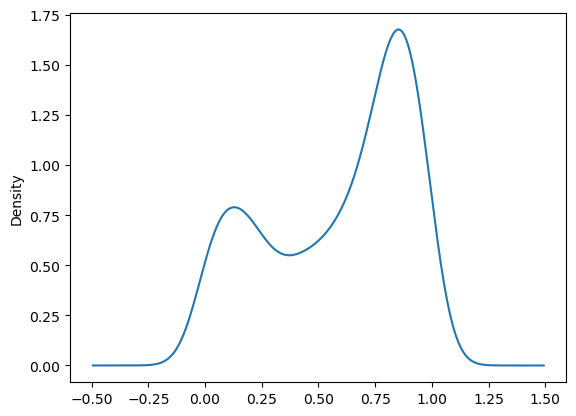

In [66]:
df1.prediction.plot(kind='kde')

<AxesSubplot:ylabel='Density'>

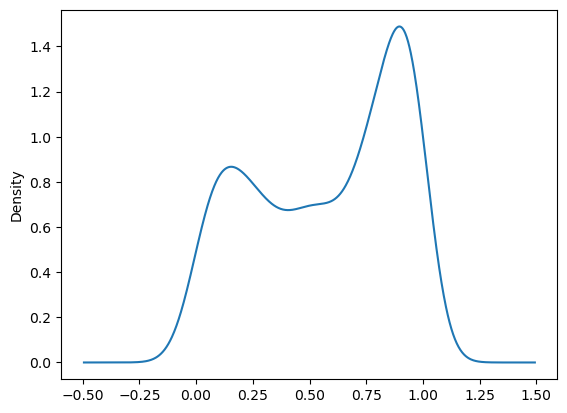

In [67]:
df2.prediction.plot(kind='kde')

In [ ]:
df3.pred

In [78]:
np.savez('./lgbm_save',train_fold = train_fold_pred, test_pred = test_pred_mean)

### 탭넷 stacking

In [5]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
def categorical_feature(data : pd.DataFrame,columns : list) -> pd.DataFrame:
    for col in columns:
        X = data[col]
        enc = LabelEncoder()
        enc.fit(X)
        data[col] = enc.transform(X)
    return data

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
df2 = pd.read_pickle(after_fe_path)
df2 = categorical_feature(df2,lgbm_cat_feats)
df2.loc[:,lgbm_FEATS] = df2.loc[:,lgbm_FEATS].fillna(0)
cat_idxs = [df2[lgbm_FEATS].columns.get_loc(col) for col in lgbm_cat_feats]
cat_dims = [df2[col].nunique() for col in lgbm_cat_feats]
test_set_tn = df2[df2['answerCode'] == -1]
df2 = df2[df2['answerCode'] != -1]
fold_train_tn, fold_valid_tn = k_fold_split(df2,fold=5)

In [8]:
TabNet = TabNetClassifier(
    seed = 42,
    n_d = 8,
    n_a = 8,
    n_steps = 3,
    gamma = 1.3,
    n_independent = 2,
    n_shared = 3,
    cat_emb_dim=2,
    optimizer_params=dict(lr=0.01),
    momentum=0.1,
    cat_idxs= cat_idxs,
    cat_dims= cat_dims,
    verbose=1,
    mask_type = 'sparsemax',
    lambda_sparse = 0,
    clip_value = 1.0,
    device_name="cuda"
)

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [10]:
tn_train_fold_pred, tn_test_pred_mean = get_stacking_base_datasets(
    TabNet,
    lgbm_FEATS,
    None,
    fold_train_tn,
    fold_valid_tn,
    test_set_tn,
    5)

TabNetClassifier  model 시작 
	 폴드 세트:  0  시작 
epoch 0  | loss: 0.52081 | val_0_auc: 0.81593 |  0:02:33s
epoch 1  | loss: 0.49925 | val_0_auc: 0.82264 |  0:05:03s
epoch 2  | loss: 0.49162 | val_0_auc: 0.82461 |  0:07:34s
epoch 3  | loss: 0.48274 | val_0_auc: 0.82554 |  0:09:57s
epoch 4  | loss: 0.47463 | val_0_auc: 0.82806 |  0:12:28s
epoch 5  | loss: 0.46897 | val_0_auc: 0.82984 |  0:14:56s
epoch 6  | loss: 0.46626 | val_0_auc: 0.83461 |  0:17:21s
epoch 7  | loss: 0.46388 | val_0_auc: 0.83133 |  0:19:50s
epoch 8  | loss: 0.46309 | val_0_auc: 0.83299 |  0:22:16s
epoch 9  | loss: 0.46151 | val_0_auc: 0.83514 |  0:24:43s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_auc = 0.83514


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


	 0 fold auc :  0.8351386400872383
	 폴드 세트:  1  시작 
epoch 0  | loss: 0.52534 | val_0_auc: 0.82671 |  0:02:26s
epoch 1  | loss: 0.50084 | val_0_auc: 0.83522 |  0:04:52s
epoch 2  | loss: 0.4937  | val_0_auc: 0.83527 |  0:07:20s
epoch 3  | loss: 0.4826  | val_0_auc: 0.84544 |  0:09:49s
epoch 4  | loss: 0.47408 | val_0_auc: 0.84167 |  0:12:18s
epoch 5  | loss: 0.46948 | val_0_auc: 0.84611 |  0:14:41s
epoch 6  | loss: 0.46528 | val_0_auc: 0.8481  |  0:17:06s
epoch 7  | loss: 0.46423 | val_0_auc: 0.84286 |  0:19:31s
epoch 8  | loss: 0.4627  | val_0_auc: 0.84581 |  0:21:53s
epoch 9  | loss: 0.46085 | val_0_auc: 0.84769 |  0:24:14s

Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_0_auc = 0.8481


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


	 1 fold auc :  0.848095807928277
	 폴드 세트:  2  시작 
epoch 0  | loss: 0.52289 | val_0_auc: 0.81578 |  0:02:21s
epoch 1  | loss: 0.49592 | val_0_auc: 0.81984 |  0:04:41s
epoch 2  | loss: 0.48889 | val_0_auc: 0.82453 |  0:07:06s
epoch 3  | loss: 0.4796  | val_0_auc: 0.82405 |  0:09:29s
epoch 4  | loss: 0.47169 | val_0_auc: 0.82772 |  0:11:52s
epoch 5  | loss: 0.46796 | val_0_auc: 0.82736 |  0:14:13s
epoch 6  | loss: 0.46496 | val_0_auc: 0.83215 |  0:16:36s
epoch 7  | loss: 0.463   | val_0_auc: 0.83257 |  0:18:59s
epoch 8  | loss: 0.46262 | val_0_auc: 0.83132 |  0:21:19s
epoch 9  | loss: 0.46164 | val_0_auc: 0.82872 |  0:23:43s
Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_0_auc = 0.83257


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


	 2 fold auc :  0.8325698648312463
	 폴드 세트:  3  시작 
epoch 0  | loss: 0.5227  | val_0_auc: 0.83587 |  0:01:56s
epoch 1  | loss: 0.49915 | val_0_auc: 0.83604 |  0:03:56s
epoch 2  | loss: 0.48988 | val_0_auc: 0.83665 |  0:05:59s
epoch 3  | loss: 0.48164 | val_0_auc: 0.84553 |  0:07:57s
epoch 4  | loss: 0.47327 | val_0_auc: 0.84737 |  0:09:49s
epoch 5  | loss: 0.46904 | val_0_auc: 0.84695 |  0:11:40s
epoch 6  | loss: 0.46623 | val_0_auc: 0.84807 |  0:13:34s
epoch 7  | loss: 0.46485 | val_0_auc: 0.84888 |  0:15:40s
epoch 8  | loss: 0.46225 | val_0_auc: 0.84953 |  0:17:43s
epoch 9  | loss: 0.46141 | val_0_auc: 0.84822 |  0:19:38s
Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_0_auc = 0.84953


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


	 3 fold auc :  0.8495264367816092
	 폴드 세트:  4  시작 
epoch 0  | loss: 0.52221 | val_0_auc: 0.82502 |  0:02:21s
epoch 1  | loss: 0.49843 | val_0_auc: 0.83009 |  0:04:40s
epoch 2  | loss: 0.49247 | val_0_auc: 0.83321 |  0:07:04s
epoch 3  | loss: 0.48406 | val_0_auc: 0.83236 |  0:09:24s
epoch 4  | loss: 0.4753  | val_0_auc: 0.83496 |  0:11:49s
epoch 5  | loss: 0.47123 | val_0_auc: 0.84035 |  0:14:08s
epoch 6  | loss: 0.46741 | val_0_auc: 0.84137 |  0:16:27s
epoch 7  | loss: 0.4656  | val_0_auc: 0.83216 |  0:18:48s
epoch 8  | loss: 0.46449 | val_0_auc: 0.84099 |  0:21:12s
epoch 9  | loss: 0.46273 | val_0_auc: 0.83624 |  0:23:33s

Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_0_auc = 0.84137


/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


	 4 fold auc :  0.8413732751432841
	valid auc :  0.8410939024234234


In [11]:
np.savez('./tabnet_save',train_fold = tn_train_fold_pred, test_pred = tn_test_pred_mean)

### Catboost Parameter 설정

In [4]:
# model.fit(
#             X_train, y_train,
#             cat_features=dataset.cat_features,
#             eval_set=(X_valid, y_valid),
#             verbose=args.verbose,
#         )

catboost_FEAT = ['userID', 
      'assessmentItemID',
       'testId',
       'KnowledgeTag',
        'big_category',
        'mid_category',
        'problem_num',
        'month',
        'day',
        'test_solvesec',
        'dayname',
       'hour',
       'user_correct_answer',
        'user_total_answer',
        'user_acc',
        'user_BC_correct_answer',
        'user_BC_total_answer',
        'user_BC_acc',
        'user_testId_correct_answer',
        'user_testId_total_answer',
        'user_testId_acc',
        'correctRatio__by_test_paper',
       'correctRatio__by_prob', 
      'correctRatio__by_BC',
      'answerCode'
        ]

catboost_CAT_FEAT = ['userID','assessmentItemID','testId',
            'KnowledgeTag',
            'big_category','mid_category',
            'problem_num',
            'dayname',
            'month',
            'day',
            'dayname',
            'hour'
            ]

catboost = CatBoostClassifier(iterations=10000,
                              random_seed=42,
                              custom_metric=["AUC", "Accuracy"],
                              eval_metric="AUC",
                              early_stopping_rounds=100,
                              learning_rate=0.01,
                              task_type="GPU",
                              devices="0")
catboost_fit_parameter = {
  'cat_features' : catboost_CAT_FEAT,
  'verbose' : 1000
}

### catboost DataLoad

In [5]:
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'catboost_data_3.pkl')
df = pd.read_pickle(after_fe_path)


In [6]:
num_features = list(set(catboost_FEAT) - set(catboost_CAT_FEAT))
for cat_feat in catboost_CAT_FEAT:
    df[cat_feat] = df[cat_feat].astype("category")
for num_feat in num_features:
    df[num_feat] = df[num_feat].astype(float)

In [7]:
df['answerCode'] = df['answerCode'].astype("int")

In [9]:
train_idx = np.load('./train_idx.npy',allow_pickle = True)
valid_idx = np.load('./valid_idx.npy',allow_pickle = True)

In [12]:
test_set = df[df['answerCode'] == -1]
df = df[df['answerCode'] != -1]
fold_train, fold_valid = train_valid_idx(df,train_idx,valid_idx,5)

In [13]:
fold = 5
print(f"총 user 수 : {df['userID'].nunique()}")
for i in range(fold):
    print(f"train_{i} user 수 : {fold_train[i]['userID'].nunique()}")
    print(f"test_{i} user 수 : {fold_valid[i]['userID'].nunique()}")
    print(f"겹치는 유저가 있나?? : {set(fold_train[i]['userID'])&set(fold_valid[i]['userID'])}")

총 user 수 : 7442
train_0 user 수 : 5942
test_0 user 수 : 1500
겹치는 유저가 있나?? : set()
train_1 user 수 : 5989
test_1 user 수 : 1453
겹치는 유저가 있나?? : set()
train_2 user 수 : 5889
test_2 user 수 : 1553
겹치는 유저가 있나?? : set()
train_3 user 수 : 5967
test_3 user 수 : 1475
겹치는 유저가 있나?? : set()
train_4 user 수 : 5981
test_4 user 수 : 1461
겹치는 유저가 있나?? : set()


In [14]:
cb_train_fold_pred, cb_test_pred_mean = get_stacking_base_datasets(
            catboost,
            catboost_FEAT,
            catboost_fit_parameter,
            fold_train,fold_valid,test_set,5)

CatBoostClassifier  model 시작 
	 폴드 세트:  0  시작 


TypeError: unsupported operand type(s) for ** or pow(): 'tuple' and 'dict'

In [ ]:
np.savez('./catboost_save',train_fold = cb_train_fold_pred, test_pred = cb_test_pred_mean)

### final stacking

In [ ]:
def stacking_pred(models,FEATS,args,X_train, X_valid, X_test, n_folds):
    valid_len = 0
    stack_y_train = X_valid[0]['answerCode']

    for i,v in enumerate(X_valid):
        valid_len += len(v)
        if i != 0:
            stack_y_train = pd.concat([stack_y_train,v['answerCode']])
    
    stack_X_train = np.zeros((valid_len,len(models)))
    stack_X_test = np.zeros((len(X_test),len(models)))

    for i,(model,FEAT,arg) in enumerate(zip(models,FEATS,args)):
        train_fold_pred, test_pred_mean = get_stacking_base_datasets(model,FEAT,arg,X_train, X_valid, X_test, n_folds)
        stack_X_train[:,i] = train_fold_pred.reshape(-1)
        stack_X_test[:,i] = test_pred_mean.reshape(-1)
    
    final_model = LGBMClassifier()
    final_model.fit(
        stack_X_train,stack_y_train
    )
    
    train_preds = final_model.predict_proba(stack_X_train)[:,1]
    print("final train auc : ",roc_auc_score(stack_y_train,train_preds))

    final_preds = final_model.predict_proba(stack_X_test)[:,1]
    return final_preds

In [31]:
def stacking_pred(models,FEATS,args,X_train, X_valid, X_test, n_folds):
    valid_len = 0
    stack_y_train = X_valid[0]['answerCode']

    for i,v in enumerate(X_valid):
        valid_len += len(v)
        if i != 0:
            stack_y_train = pd.concat([stack_y_train,v['answerCode']])
    
    stack_X_train = np.zeros((valid_len,len(models)))
    stack_X_test = np.zeros((len(X_test),len(models)))

    for i,(model,FEAT,arg) in enumerate(zip(models,FEATS,args)):
        train_fold_pred, test_pred_mean = get_stacking_base_datasets(model,FEAT,arg,X_train, X_valid, X_test, n_folds)
        stack_X_train[:,i] = train_fold_pred.reshape(-1)
        stack_X_test[:,i] = test_pred_mean.reshape(-1)
    
    final_model = LGBMClassifier()
    final_model.fit(
        stack_X_train,stack_y_train
    )
    
    train_preds = final_model.predict_proba(stack_X_train)[:,1]
    print("final train auc : ",roc_auc_score(stack_y_train,train_preds))

    final_preds = final_model.predict_proba(stack_X_test)[:,1]
    return final_preds


In [ ]:
from datetime import datetime
from pytz import timezone

now = datetime.now(tz = timezone('Asia/Seoul'))
date_str = now.strftime('%m-%d-%H:%M:%S')
submission = pd.read_csv('../../data/sample_submission.csv')
submission['prediction'] = test_pred
submission.to_csv('./submission/stacking'+date_str+'.csv')